# SSCx Dissemination.

We analyze circuits developed under the SSCx Dissemination project.


In [1]:
from collections import OrderedDict
from tqdm import tqdm
from dmt.tk.plotting import Bars, LinePlot, Crosses
from dmt.data.observation import measurement
from dmt.tk.plotting.multi import MultiPlot
from neuro_dmt.models.bluebrain.circuit.geometry import Cuboid
from neuro_dmt.library.users.visood.sscx_dissemination.analyses import *

While using this notebook for development, we might need to reload the adapter:

In [2]:
sscxdiss = SSCxDisseminationCircuit()

In [3]:
sscxdiss.variations

bio0: Not Available
bio1: Not Available
bio2: Not Available
bio3: Not Available
bio4: Not Available
bio5: Not Available
biom: 'Bio_M/20191206'
mock: 'MOCK'

We will need to parameterize our analysis:

In [4]:
spec = AnalysisParameterization()
spec.field_dict

{'morphologies_interneurons': ['BP',
  'BTC',
  'CHC',
  'DB',
  'LBC',
  'NBC',
  'MC',
  'SBC',
  'SSC'],
 'number_cortical_thickness_bins': 50,
 'path_reports': '/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports',
 'sample_size': 100,
 'size_roi': array([50., 50., 50.])}

In [5]:
#circuit_model = sscxdiss.circuit(sscxdiss.variations.mock)
circuit_model = sscxdiss.circuit(sscxdiss.variations.biom)
adapter = sscxdiss.adapter

In [6]:
from importlib import reload
from neuro_dmt.models.bluebrain.circuit.adapter import adapter as ad
from neuro_dmt.models.bluebrain.circuit import model as md
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.tools\
    import pathway_measurement as pm
from neuro_dmt.analysis import reporting as rp
adapter =\
    ad.BlueBrainCircuitAdapter()
model =\
    md.BlueBrainCircuitModel()
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))

 We will develop our analysis of the SSCx Dissemination circuits as a growing
 list of analyzed phenomena:

In [7]:
phenomenon = OrderedDict()

For each **DMT** analysis we will need to define an interface defining the
methods that the analysis uses to query a circuit model.
Instead of defining an interface for each analysis, we have collected all the
interface methods for composition and connectome analyses:

In [8]:
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.composition\
    import CompositionAnalysesSuite
CompositionAdapterInterface = CompositionAnalysesSuite.AdapterInterface

To save reports, we will use a reporter.

In [9]:
from neuro_dmt.analysis.reporting import CheetahReporter
reporter = CheetahReporter(
    path_output_folder=os.path.join(
        spec.path_reports, "analyses"))

# Circuit Composition
Rat *Somatoseonsory Cortex* circuits are atlas based.
Four sub-regions of the SSCx were populated:ec

In [10]:
populated_regions =\
    adapter.get_brain_regions(circuit_model)
populated_regions

[S1FL, S1Sh, S1HL, S1Tr]
Categories (4, object): [S1FL, S1Sh, S1HL, S1Tr]

We will use parameters to measure composition phenomena:

In [11]:
def get_regions(adapter, model):
    """
    Get regions...
    """
    return pd.DataFrame(
        adapter.get_brain_regions(model),
        columns=["region"])

def get_layers(adapter, model):
    """..."""
    return pd.DataFrame(
        adapter.get_layers(model),
        columns=["layer"])
    
def get_regions_and_layers(adapter, model):
    """
    Get regions and layers for the model.
    """
    regions = adapter.get_brain_regions(model)
    layers = adapter.get_layers(model)
    return pd.DataFrame(
        [[region, layer] for region in regions for layer in layers],
        columns=["region", "layer"])

We can count the number of cells in each region.
We will use **DMT** to define and run analyses. 
A DMT analysis requires a method to measure the analyzed phenomenon.
We define such a method to count cells:

## SSCx Subregions

Four sub-regions of the SSCx were populated:

### Region Volumes

To get an idea about the relative sizes of layers and sub-regions, we analyze
the volume of each modulated sub-region, layer pair in the circuit.

In [12]:
def measurement_region_volume(
        adapter, circuit_model,
        **query):
    """
    Volume of the region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.get_spatial_volume(circuit_model, **spatial_query)

def add_total_volume(measurement):
    return\
        pd.concat([
            measurement,
            measurement.groupby(["dataset", "region"])\
                       .agg("sum")\
                       .assign(layer="total")\
                       .reset_index()\
                       .set_index(["dataset", "region", "layer"])])

phenomenon["region_volume"] =\
    Phenomenon(
        "Volume",
        description="Volume of a brain-region.",
        group="Composition")
analysis_region_volumes =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["region_volume"],
        introduction="""
        Volumes of the populated subregions and layers of SSCx are analyzed.
        """,
        methods="""
        Voxels were counted in each sub-region, layer were counted and 
        multiplied with voxel volume.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_region_volume,
        add_columns = add_total_volume,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="volume",
                     ylabel="Volume",
                     gvar="layer"),
        report=CircuitAnalysisReport)

100%|██████████| 24/24 [01:14<00:00,  3.09s/it]


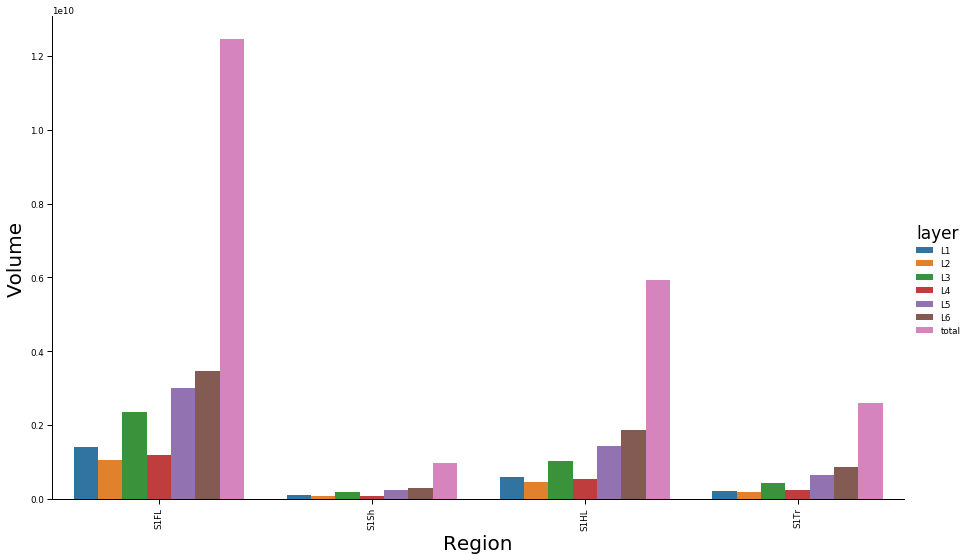

In [15]:
report_volumes = analysis_region_volumes(circuit_model, adapter)

In [16]:
reload(rp)
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))
reporter.post(report_volumes)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:41:52>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x14e4a34d0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:41:52>                                                      
Post report volume at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/s

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/volume/20200306/154856'

### Layer Thickness

Layer thickness is tricky to define for an atlas based circuit.
We expect that for a given sub-region a sample of layer thicknesses can be drawn.
Our next analysis uses this technique and plots the distribution of drawn samples
for each sub-region.

In [70]:
def measurement_thickness(
        adapter, circuit_model,
        region=None,
        **kwargs):
    """
    Measure layer thickness in the given region.
    """
    wide = adapter.get_layer_thickness_values(circuit_model, region=region)
    wide.columns.name = "layer"
    return\
        pd.concat([wide.iloc[i] for i in range(wide.shape[0])])\
          .rename("thickness")

In [96]:
phenomenon["thickness"] =\
    Phenomenon(
        "Thickness",
        description="Thickness of layers.",
        group="Composition")

analysis_layer_thickness =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["thickness"],
        introduction="""
        Thickness of layers measured in each region modeled in the circuit.
        """,
        methods="""
        Thickness of layers were measured as the shortest top-bottom line
        passing through each voxel in the voxelized space.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions),
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_measurement=measurement_thickness,
        measurement_collection=measurement.collection.series_type,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="thickness",
                     ylabel="Thickness",
                     gvar="layer"),
        report=CircuitAnalysisReport)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:24<01:12, 24.28s/it]



 50%|█████     | 2/4 [00:50<00:49, 24.99s/it]



 75%|███████▌  | 3/4 [01:13<00:24, 24.37s/it]



100%|██████████| 4/4 [01:37<00:00, 24.27s/it]


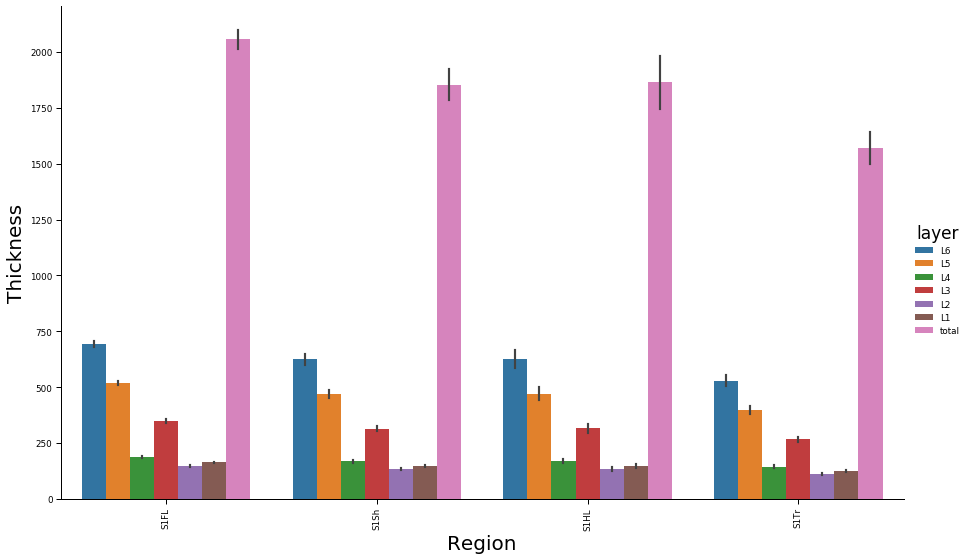

In [97]:
report_thickness =\
    analysis_layer_thickness(circuit_model, adapter)

In [98]:
reporter.post(report_thickness)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x19b46dcd0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:56:00>                                                      
Post report thickness at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visoo

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/thickness/20200306/175218'

## Cell Distribution

In this section we study the distribution of cells over the physical geometry
of the circuit.


In [105]:
def random_position(
        adapter, circuit_model,
        **query):
    """
    Random position in circuit region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.random_position(circuit_model, **spatial_query)
    
def random_box(
        adapter, circuit_model, 
        size_roi=100., **query):
    """
    Random cuboid in circuit region specified by `query`.
    """
    position = random_position(adapter, circuit_model, **query)
    return Cuboid(position - size_roi, position + size_roi)\
        if position is not None else None

def measurement_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    return adapter.get_cells(circuit_model, roi=box).shape[0]\
        if box is not None else 0.

### Cell Count

Circuit regions and layers are not the same size, and contain different densities
of cells.

In [108]:
phenomenon["cell_count"] =\
    Phenomenon("Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
analysis_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_count_using_sampling,
        sample_size=20,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="cell_count",
                     ylabel="Cell Count",
                     gvar="layer"),
        report=CircuitAnalysisReport)
                                       






  0%|          | 0/480 [00:00<?, ?it/s]




  1%|          | 3/480 [00:00<00:19, 24.31it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x153113c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x153113c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19620f090>}

/Users/vi






  1%|▏         | 6/480 [00:00<00:20, 23.04it/s]




  2%|▏         | 9/480 [00:00<00:19, 24.48it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebc8c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebc8c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26cd0>}

/Users/vi






  2%|▎         | 12/480 [00:00<00:18, 25.04it/s]




  3%|▎         | 15/480 [00:00<00:18, 25.63it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c5dd0>}

/Users/vi






  4%|▍         | 18/480 [00:00<00:17, 26.61it/s]




  4%|▍         | 21/480 [00:00<00:17, 26.39it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebc8910>}

/Users/vi






  5%|▌         | 24/480 [00:00<00:18, 24.87it/s]




  6%|▌         | 27/480 [00:01<00:18, 24.52it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26b10>}

/Users/vi






  6%|▋         | 30/480 [00:01<00:18, 24.01it/s]




  7%|▋         | 33/480 [00:01<00:18, 23.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17eba7c10>}

/Users/vi






  8%|▊         | 36/480 [00:01<00:18, 23.72it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b690>}

/Users/vi






  8%|▊         | 39/480 [00:01<00:18, 23.65it/s]




  9%|▉         | 42/480 [00:01<00:19, 22.50it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c56d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c56d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c56d0>}

/Users/vi






  9%|▉         | 45/480 [00:01<00:19, 22.18it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ecc4810>}

/Users/vi






 10%|█         | 48/480 [00:02<00:20, 20.99it/s]




 11%|█         | 51/480 [00:02<00:19, 21.63it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180682950>}

/Users/vi






 11%|█▏        | 54/480 [00:02<00:19, 21.50it/s]




 12%|█▏        | 57/480 [00:02<00:20, 20.95it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bbd0>}

/Users/vi






 12%|█▎        | 60/480 [00:02<00:20, 20.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806825d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806825d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806825d0>}

/Users/vi






 13%|█▎        | 63/480 [00:02<00:20, 20.61it/s]




 14%|█▍        | 66/480 [00:02<00:19, 21.05it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bd50>}

/Users/vi






 14%|█▍        | 69/480 [00:03<00:20, 20.29it/s]




 15%|█▌        | 72/480 [00:03<00:19, 20.83it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c5cd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c5cd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005790>}

/Users/vi






 16%|█▌        | 75/480 [00:03<00:19, 20.91it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa264d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa264d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180682450>}

/Users/vi






 16%|█▋        | 78/480 [00:03<00:18, 21.51it/s]




 17%|█▋        | 81/480 [00:03<00:18, 21.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be690>}

/Users/vi






 18%|█▊        | 84/480 [00:03<00:18, 21.05it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26110>}

/Users/vi






 18%|█▊        | 87/480 [00:03<00:19, 20.11it/s]




 19%|█▉        | 90/480 [00:04<00:19, 19.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497ba90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497ba90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bef10>}

/Users/vi






 19%|█▉        | 93/480 [00:04<00:18, 20.50it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa050>}

/Users/vi






 20%|██        | 96/480 [00:04<00:18, 20.59it/s]




 21%|██        | 99/480 [00:04<00:18, 20.74it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fac10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fac10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fac10>}

/Users/vi






 21%|██▏       | 102/480 [00:04<00:18, 20.83it/s]




 22%|██▏       | 105/480 [00:04<00:17, 21.43it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7cbd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7cbd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7cbd0>}

/Users/vi






 22%|██▎       | 108/480 [00:04<00:18, 20.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bec50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bec50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bedd0>}

/Users/vi






 23%|██▎       | 111/480 [00:05<00:17, 21.01it/s]




 24%|██▍       | 114/480 [00:05<00:17, 20.60it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5890>}

/Users/vi






 24%|██▍       | 117/480 [00:05<00:16, 21.45it/s]




 25%|██▌       | 120/480 [00:05<00:16, 21.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bedd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bedd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa710>}

/Users/vi






 26%|██▌       | 123/480 [00:05<00:15, 22.44it/s]




 26%|██▋       | 126/480 [00:05<00:14, 24.21it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bea10>}

/Users/vi






 27%|██▋       | 129/480 [00:05<00:14, 24.82it/s]




 28%|██▊       | 132/480 [00:05<00:14, 24.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98890>}

/Users/vi






 28%|██▊       | 135/480 [00:06<00:13, 25.81it/s]




 29%|██▉       | 139/480 [00:06<00:12, 27.44it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5f10>}

/Users/vi






 30%|██▉       | 142/480 [00:06<00:12, 27.19it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180682750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180682750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005310>}

/Users/vi






 30%|███       | 145/480 [00:06<00:14, 22.94it/s]




 31%|███       | 148/480 [00:06<00:15, 21.68it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955650>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955650>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955d90>}

/Users/vi






 31%|███▏      | 151/480 [00:06<00:15, 21.74it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be810>}

/Users/vi






 32%|███▏      | 154/480 [00:06<00:15, 20.67it/s]




 33%|███▎      | 157/480 [00:07<00:15, 20.48it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7c510>}

/Users/vi






 33%|███▎      | 160/480 [00:07<00:15, 21.32it/s]




 34%|███▍      | 163/480 [00:07<00:14, 21.68it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f50d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f50d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fac50>}

/Users/vi






 35%|███▍      | 166/480 [00:07<00:14, 22.17it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005c50>}

/Users/vi






 35%|███▌      | 169/480 [00:07<00:14, 21.66it/s]




 36%|███▌      | 172/480 [00:07<00:14, 21.34it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vi






 36%|███▋      | 175/480 [00:07<00:13, 21.81it/s]




 37%|███▋      | 178/480 [00:08<00:13, 22.13it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57f10>}

/Users/vi






 38%|███▊      | 181/480 [00:08<00:13, 22.25it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa01790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa01790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa01d90>}

/Users/vi






 38%|███▊      | 184/480 [00:08<00:13, 22.44it/s]




 39%|███▉      | 187/480 [00:08<00:12, 22.81it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vi






 40%|███▉      | 190/480 [00:08<00:12, 23.00it/s]




 40%|████      | 193/480 [00:08<00:12, 23.69it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19a7f23d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19a7f23d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b190>}

/Users/vi






 41%|████      | 196/480 [00:08<00:12, 23.53it/s]




 41%|████▏     | 199/480 [00:08<00:12, 22.53it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1599550d0>}

/Users/vi






 42%|████▏     | 202/480 [00:09<00:12, 22.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1e90>}

/Users/vi






 43%|████▎     | 205/480 [00:09<00:11, 23.24it/s]




 43%|████▎     | 208/480 [00:09<00:11, 23.73it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1f10>}

/Users/vi






 44%|████▍     | 211/480 [00:09<00:11, 23.85it/s]




 45%|████▍     | 214/480 [00:09<00:11, 23.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa6d0>}

/Users/vi






 45%|████▌     | 217/480 [00:09<00:10, 24.44it/s]




 46%|████▌     | 220/480 [00:09<00:10, 24.19it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7c510>}

/Users/vi






 46%|████▋     | 223/480 [00:09<00:10, 23.50it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57310>}

/Users/vi






 47%|████▋     | 226/480 [00:10<00:10, 23.75it/s]




 48%|████▊     | 229/480 [00:10<00:10, 23.29it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1bd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1bd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1bd0>}

/Users/vi






 48%|████▊     | 232/480 [00:10<00:11, 22.19it/s]




 49%|████▉     | 235/480 [00:10<00:11, 21.97it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa01e10>}

/Users/vi






 50%|████▉     | 238/480 [00:10<00:11, 21.44it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1599557d0>}

/Users/vi






 50%|█████     | 241/480 [00:10<00:10, 22.21it/s]




 51%|█████     | 244/480 [00:10<00:10, 23.28it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941050>}

/Users/vi






 51%|█████▏    | 247/480 [00:10<00:09, 24.48it/s]




 52%|█████▏    | 250/480 [00:11<00:09, 25.15it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1599557d0>}

/Users/vi






 53%|█████▎    | 254/480 [00:11<00:08, 26.48it/s]




 54%|█████▎    | 257/480 [00:11<00:08, 26.66it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec979d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec979d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031510>}

/Users/vi






 54%|█████▍    | 261/480 [00:11<00:07, 27.41it/s]




 55%|█████▌    | 264/480 [00:11<00:08, 24.80it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1f10>}

/Users/vi






 56%|█████▌    | 267/480 [00:11<00:08, 24.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103e10>}

/Users/vi






 56%|█████▋    | 270/480 [00:11<00:09, 23.10it/s]




 57%|█████▋    | 273/480 [00:11<00:08, 23.77it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97690>}

/Users/vi






 57%|█████▊    | 276/480 [00:12<00:09, 21.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031310>}

/Users/vi






 58%|█████▊    | 279/480 [00:12<00:09, 21.27it/s]




 59%|█████▉    | 282/480 [00:12<00:09, 21.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955990>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955990>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1590>}

/Users/vi






 59%|█████▉    | 285/480 [00:12<00:09, 21.35it/s]




 60%|██████    | 288/480 [00:12<00:08, 21.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26cd0>}

/Users/vi






 61%|██████    | 291/480 [00:12<00:08, 21.24it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031250>}

/Users/vi






 61%|██████▏   | 294/480 [00:12<00:08, 21.57it/s]




 62%|██████▏   | 297/480 [00:13<00:08, 21.60it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b290>}

/Users/vi






 62%|██████▎   | 300/480 [00:13<00:08, 21.77it/s]




 63%|██████▎   | 303/480 [00:13<00:07, 22.26it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941510>}

/Users/vi






 64%|██████▍   | 306/480 [00:13<00:07, 22.65it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa890>}

/Users/vi






 64%|██████▍   | 309/480 [00:13<00:07, 22.14it/s]




 65%|██████▌   | 312/480 [00:13<00:07, 22.75it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596110>}

/Users/vi






 66%|██████▌   | 315/480 [00:13<00:07, 22.82it/s]




 66%|██████▋   | 318/480 [00:14<00:07, 22.95it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97750>}

/Users/vi






 67%|██████▋   | 321/480 [00:14<00:06, 23.11it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b810>}

/Users/vi






 68%|██████▊   | 324/480 [00:14<00:06, 22.56it/s]




 68%|██████▊   | 327/480 [00:14<00:06, 22.89it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19811a050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19811a050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19811a050>}

/Users/vi






 69%|██████▉   | 330/480 [00:14<00:06, 22.64it/s]




 69%|██████▉   | 333/480 [00:14<00:06, 23.46it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1d50>}

/Users/vi






 70%|███████   | 336/480 [00:14<00:06, 22.99it/s]




 71%|███████   | 339/480 [00:14<00:06, 23.40it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980faa90>}

/Users/vi






 71%|███████▏  | 342/480 [00:15<00:05, 23.61it/s]






/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fe8c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fe8c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26cd0>}

/Users/vi

 72%|███████▏  | 345/480 [00:15<00:05, 23.72it/s]




 72%|███████▎  | 348/480 [00:15<00:05, 22.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b0d0>}

/Users/vi






 73%|███████▎  | 351/480 [00:15<00:05, 23.33it/s]




 74%|███████▍  | 354/480 [00:15<00:05, 23.45it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec976d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec976d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec976d0>}

/Users/vi






 74%|███████▍  | 357/480 [00:15<00:05, 23.40it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf8d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf8d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf490>}

/Users/vi






 75%|███████▌  | 360/480 [00:15<00:05, 22.31it/s]




 76%|███████▌  | 363/480 [00:15<00:04, 23.77it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf290>}

/Users/vi






 76%|███████▋  | 367/480 [00:16<00:04, 25.90it/s]




 77%|███████▋  | 371/480 [00:16<00:03, 28.25it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97b50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97b50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97b50>}

/Users/vi






 78%|███████▊  | 375/480 [00:16<00:03, 29.49it/s]




 79%|███████▉  | 379/480 [00:16<00:03, 30.02it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1c10>}

/Users/vi






 80%|███████▉  | 383/480 [00:16<00:03, 27.96it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4790>}

/Users/vi






 80%|████████  | 386/480 [00:16<00:03, 26.31it/s]




 81%|████████  | 389/480 [00:16<00:03, 25.12it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1550f6550>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1550f6550>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4350>}

/Users/vi






 82%|████████▏ | 392/480 [00:17<00:03, 24.53it/s]




 82%|████████▏ | 395/480 [00:17<00:03, 24.23it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f53d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f53d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b390>}

/Users/vi






 83%|████████▎ | 398/480 [00:17<00:03, 23.85it/s]






/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108f50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108f50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108f50>}

/Users/vi

 84%|████████▎ | 401/480 [00:17<00:03, 24.25it/s]




 84%|████████▍ | 404/480 [00:17<00:03, 23.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97610>}

/Users/vi






 85%|████████▍ | 407/480 [00:17<00:03, 23.83it/s]




 85%|████████▌ | 410/480 [00:17<00:03, 22.83it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1550f6410>}

/Users/vi






 86%|████████▌ | 413/480 [00:17<00:02, 23.22it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b950>}

/Users/vi






 87%|████████▋ | 416/480 [00:18<00:02, 23.33it/s]




 87%|████████▋ | 419/480 [00:18<00:02, 23.70it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4b50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4b50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b790>}

/Users/vi






 88%|████████▊ | 422/480 [00:18<00:02, 24.04it/s]




 89%|████████▊ | 425/480 [00:18<00:02, 24.13it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bfa90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bfa90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b3d0>}

/Users/vi






 89%|████████▉ | 428/480 [00:18<00:02, 23.31it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebb3590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebb3590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005c50>}

/Users/vi






 90%|████████▉ | 431/480 [00:18<00:02, 23.55it/s]




 90%|█████████ | 434/480 [00:18<00:01, 23.61it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1551087d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1551087d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4350>}

/Users/vi






 91%|█████████ | 437/480 [00:18<00:01, 23.23it/s]




 92%|█████████▏| 440/480 [00:19<00:01, 23.23it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b590>}

/Users/vi






 92%|█████████▏| 443/480 [00:19<00:01, 23.08it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bfd10>}

/Users/vi






 93%|█████████▎| 446/480 [00:19<00:01, 23.38it/s]




 94%|█████████▎| 449/480 [00:19<00:01, 23.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b4d0>}

/Users/vi






 94%|█████████▍| 452/480 [00:19<00:01, 23.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebb3d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebb3d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b550>}

/Users/vi






 95%|█████████▍| 455/480 [00:19<00:01, 21.50it/s]




 95%|█████████▌| 458/480 [00:19<00:01, 21.53it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989412d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989412d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b150>}

/Users/vi






 96%|█████████▌| 461/480 [00:20<00:00, 21.08it/s]




 97%|█████████▋| 464/480 [00:20<00:00, 22.27it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b1d0>}

/Users/vi






 97%|█████████▋| 467/480 [00:20<00:00, 21.92it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9c3350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9c3350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9c3350>}

/Users/vi






 98%|█████████▊| 470/480 [00:20<00:00, 22.41it/s]




 99%|█████████▊| 473/480 [00:20<00:00, 22.58it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f47d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f47d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fd4c10>}

/Users/vi






 99%|█████████▉| 476/480 [00:20<00:00, 22.24it/s]




100%|█████████▉| 479/480 [00:20<00:00, 22.03it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066bcd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066bcd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b250>}

/Users/vi

100%|██████████| 480/480 [00:20<00:00, 22.99it/s]


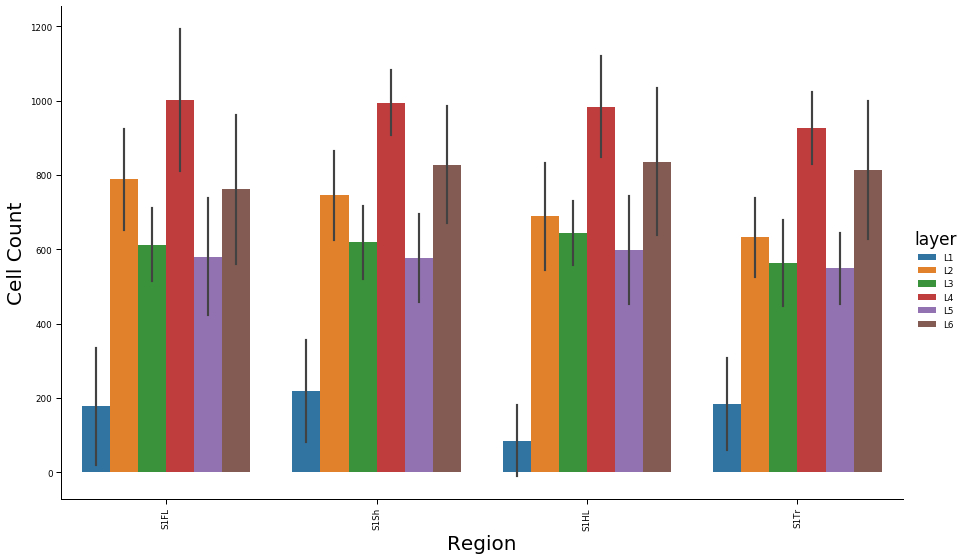

In [109]:
report_cell_count =\
    analysis_cell_count(circuit_model, adapter)

In [110]:
reporter.post(report_cell_count)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x19be57f10>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:56:00>                                                      
Post report cell_count at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/viso

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_count/20200306/183132'

### Mtype Cell Counts

We can also count cells in each region, layer by mtype.

In [132]:
phenomenon["mtype_cell_count"] =\
    Phenomenon("Mtype Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
def measurement_mtype_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box =\
        random_box(adapter, circuit_model, size_roi=size_roi, **query)
    if box is None:
        return pd.Series()
    cells = adapter.get_cells(circuit_model, roi=box)
    return cells.groupby("mtype").agg("size")

analysis_mtype_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["mtype_cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_mtype_cell_count_using_sampling,
        sample_size=20,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar="mtype",
            plotter=Bars(xvar="region",
                         xlabel="Region",
                         yvar="mtype_cell_count",
                         ylabel="Cell Count",
                         gvar="layer")),
        report=CircuitAnalysisReport)
                                       






  0%|          | 0/480 [00:00<?, ?it/s]




  0%|          | 2/480 [00:00<00:34, 13.85it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad9b90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad9b90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbff90>}

/Users/vi






  1%|          | 4/480 [00:00<00:32, 14.45it/s]




  1%|▏         | 6/480 [00:00<00:31, 14.92it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ad0add0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ad0add0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96d90>}

/Users/vi






  2%|▏         | 8/480 [00:00<00:30, 15.56it/s]




  2%|▏         | 10/480 [00:00<00:29, 15.67it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x157e0f810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x157e0f810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15678d950>}

/Users/vi






  2%|▎         | 12/480 [00:00<00:28, 16.46it/s]




  3%|▎         | 14/480 [00:00<00:28, 16.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fd4710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fd4710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fd6a90>}

/Users/vi






  3%|▎         | 16/480 [00:00<00:27, 16.77it/s]




  4%|▍         | 18/480 [00:01<00:26, 17.44it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bafa210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bafa210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebd6710>}

/Users/vi






  4%|▍         | 20/480 [00:01<00:25, 17.87it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbadd90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbadd90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96b90>}

/Users/vi






  5%|▍         | 22/480 [00:01<00:28, 15.94it/s]




  5%|▌         | 24/480 [00:01<00:28, 15.76it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be79ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be79ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180673d90>}

/Users/vi






  5%|▌         | 26/480 [00:01<00:30, 14.94it/s]




  6%|▌         | 28/480 [00:01<00:31, 14.45it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb06750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb06750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ad0add0>}

/Users/vi






  6%|▋         | 30/480 [00:01<00:33, 13.49it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc3050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc3050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbadd90>}

/Users/vi






  7%|▋         | 32/480 [00:02<00:32, 13.92it/s]




  7%|▋         | 34/480 [00:02<00:31, 14.10it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5e3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5e3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x154960450>}

/Users/vi






  8%|▊         | 36/480 [00:02<00:32, 13.73it/s]




  8%|▊         | 38/480 [00:02<00:30, 14.39it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b00cb90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b00cb90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18054f250>}

/Users/vi






  8%|▊         | 40/480 [00:02<00:29, 14.74it/s]




  9%|▉         | 42/480 [00:02<00:29, 14.73it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6a10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6a10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1549682d0>}

/Users/vi






  9%|▉         | 44/480 [00:02<00:29, 14.54it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be8de90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be8de90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806fe390>}

/Users/vi






 10%|▉         | 46/480 [00:03<00:31, 13.80it/s]




 10%|█         | 48/480 [00:03<00:31, 13.74it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17eb7ad50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17eb7ad50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17eb7ad50>}

/Users/vi






 10%|█         | 50/480 [00:03<00:30, 13.88it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb1a8d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb1a8d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb23ed0>}

/Users/vi






 11%|█         | 52/480 [00:03<00:30, 13.82it/s]




 11%|█▏        | 54/480 [00:03<00:30, 13.83it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb06150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb06150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b047f90>}

/Users/vi






 12%|█▏        | 56/480 [00:03<00:30, 13.99it/s]






/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb23e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb23e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198be93d0>}

/Users/vi

 12%|█▏        | 58/480 [00:03<00:29, 14.29it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc4d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc4d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b047f90>}

/Users/vi






 12%|█▎        | 60/480 [00:04<00:40, 10.41it/s]




 13%|█▎        | 62/480 [00:04<00:40, 10.34it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6050>}

/Users/vi






 13%|█▎        | 64/480 [00:04<00:37, 11.22it/s]




 14%|█▍        | 66/480 [00:04<00:33, 12.19it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad1050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad1050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc4d0>}

/Users/vi






 14%|█▍        | 68/480 [00:04<00:32, 12.76it/s]


/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96b90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96b90>}

/Users/vishalsoodmuchu/.v






 15%|█▍        | 70/480 [00:05<00:32, 12.50it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1807257d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1807257d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbcbd0>}

/Users/vi






 15%|█▌        | 72/480 [00:05<00:31, 12.82it/s]




 15%|█▌        | 74/480 [00:05<00:30, 13.31it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec9ee90>}

/Users/vi






 16%|█▌        | 76/480 [00:05<00:31, 12.84it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc290>}

/Users/vi






 16%|█▋        | 78/480 [00:05<00:31, 12.68it/s]




 17%|█▋        | 80/480 [00:05<00:30, 13.06it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbca10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbca10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb1aed0>}

/Users/vi






 17%|█▋        | 82/480 [00:05<00:29, 13.41it/s]




 18%|█▊        | 84/480 [00:06<00:28, 13.94it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb23910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb23910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb0df50>}

/Users/vi






 18%|█▊        | 86/480 [00:06<00:28, 13.90it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bcddd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bcddd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc9d0>}

/Users/vi






 18%|█▊        | 88/480 [00:06<00:28, 13.69it/s]




 19%|█▉        | 90/480 [00:06<00:29, 13.10it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bcd850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bcd850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96b90>}

/Users/vi






 19%|█▉        | 92/480 [00:06<00:30, 12.88it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb1aed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb1aed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198be94d0>}

/Users/vi






 20%|█▉        | 94/480 [00:06<00:28, 13.47it/s]




 20%|██        | 96/480 [00:06<00:27, 13.80it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbc850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b0058d0>}

/Users/vi






 20%|██        | 98/480 [00:07<00:27, 13.94it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbcc50>}

/Users/vi






 21%|██        | 100/480 [00:07<00:27, 13.67it/s]




 21%|██▏       | 102/480 [00:07<00:27, 13.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26d10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26d10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba710>}

/Users/vi






 22%|██▏       | 104/480 [00:07<00:27, 13.44it/s]




 22%|██▏       | 106/480 [00:07<00:26, 14.20it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198be93d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198be93d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26490>}

/Users/vi






 22%|██▎       | 108/480 [00:07<00:26, 14.20it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba6d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba6d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac267d0>}

/Users/vi






 23%|██▎       | 110/480 [00:07<00:25, 14.27it/s]




 23%|██▎       | 112/480 [00:08<00:25, 14.30it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbafd0>}

/Users/vi






 24%|██▍       | 114/480 [00:08<00:26, 13.94it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbae10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbae10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26350>}

/Users/vi






 24%|██▍       | 116/480 [00:08<00:25, 14.03it/s]




 25%|██▍       | 118/480 [00:08<00:25, 14.28it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbab50>}

/Users/vi






 25%|██▌       | 120/480 [00:08<00:25, 14.36it/s]




 25%|██▌       | 122/480 [00:08<00:23, 15.46it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbac10>}

/Users/vi






 26%|██▌       | 124/480 [00:08<00:22, 15.56it/s]




 26%|██▋       | 126/480 [00:08<00:21, 16.61it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26d10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26d10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be9a110>}

/Users/vi






 27%|██▋       | 128/480 [00:09<00:21, 16.57it/s]




 27%|██▋       | 130/480 [00:09<00:21, 16.22it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bea9dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bea9dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26b10>}

/Users/vi






 28%|██▊       | 132/480 [00:09<00:20, 17.06it/s]




 28%|██▊       | 134/480 [00:09<00:19, 17.63it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bea9810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bea9810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba410>}

/Users/vi






 28%|██▊       | 136/480 [00:09<00:19, 17.99it/s]




 29%|██▉       | 138/480 [00:09<00:19, 17.36it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bea91d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bea91d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26a10>}

/Users/vi






 29%|██▉       | 141/480 [00:09<00:19, 17.44it/s]






/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbaf90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbaf90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26310>}

/Users/vi

 30%|██▉       | 143/480 [00:09<00:20, 16.76it/s]




 30%|███       | 145/480 [00:10<00:20, 16.25it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba690>}

/Users/vi






 31%|███       | 147/480 [00:10<00:21, 15.79it/s]




 31%|███       | 149/480 [00:10<00:20, 15.83it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26ad0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26ad0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbab90>}

/Users/vi






 31%|███▏      | 151/480 [00:10<00:21, 15.46it/s]




 32%|███▏      | 153/480 [00:10<00:21, 15.34it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba5d0>}

/Users/vi






 32%|███▏      | 155/480 [00:10<00:21, 15.47it/s]




 33%|███▎      | 157/480 [00:10<00:21, 14.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26b10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26b10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbab90>}

/Users/vi






 33%|███▎      | 159/480 [00:11<00:21, 14.77it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba6d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba6d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26b10>}

/Users/vi






 34%|███▎      | 161/480 [00:11<00:22, 14.49it/s]




 34%|███▍      | 163/480 [00:11<00:21, 14.47it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba910>}

/Users/vi






 34%|███▍      | 165/480 [00:11<00:21, 14.56it/s]






/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26b10>}

/Users/vi

 35%|███▍      | 167/480 [00:11<00:21, 14.70it/s]




 35%|███▌      | 169/480 [00:11<00:22, 14.01it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26ad0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26ad0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbab90>}

/Users/vi






 36%|███▌      | 171/480 [00:11<00:23, 12.93it/s]




 36%|███▌      | 173/480 [00:12<00:22, 13.70it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba6d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba6d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26f10>}

/Users/vi






 36%|███▋      | 175/480 [00:12<00:22, 13.51it/s]




 37%|███▋      | 177/480 [00:12<00:21, 13.87it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba5d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba5d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26f90>}

/Users/vi






 37%|███▋      | 179/480 [00:12<00:22, 13.48it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26ad0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26ad0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba350>}

/Users/vi






 38%|███▊      | 181/480 [00:12<00:22, 13.34it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbccd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbccd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19ac26f10>}

/Users/vi






 38%|███▊      | 183/480 [00:12<00:21, 13.80it/s]




 39%|███▊      | 185/480 [00:12<00:21, 13.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba190>}

/Users/vi






 39%|███▉      | 187/480 [00:13<00:21, 13.89it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbba110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc250>}

/Users/vi






 39%|███▉      | 189/480 [00:13<00:20, 13.93it/s]




 40%|███▉      | 191/480 [00:13<00:20, 14.17it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbae10>}

/Users/vi






 40%|████      | 193/480 [00:13<00:19, 14.36it/s]




 41%|████      | 195/480 [00:13<00:19, 14.51it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbcb90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbcb90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbab50>}

/Users/vi






 41%|████      | 197/480 [00:13<00:19, 14.77it/s]




 41%|████▏     | 199/480 [00:13<00:19, 14.61it/s]


/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbca90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbca90>}

/Users/vishalsoodmuchu/.v






 42%|████▏     | 201/480 [00:14<00:18, 14.82it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1c10>}

/Users/vi






 42%|████▏     | 203/480 [00:14<00:19, 14.56it/s]




 43%|████▎     | 205/480 [00:14<00:18, 14.68it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1a10>}

/Users/vi






 43%|████▎     | 207/480 [00:14<00:28,  9.72it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bea9250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bea9250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb51610>}

/Users/vi






 44%|████▎     | 209/480 [00:14<00:27,  9.87it/s]




 44%|████▍     | 211/480 [00:14<00:25, 10.70it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bebbd10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bebbd10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1ad0>}

/Users/vi






 44%|████▍     | 213/480 [00:15<00:23, 11.41it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb41390>}

/Users/vi






 45%|████▍     | 215/480 [00:15<00:21, 12.36it/s]




 45%|████▌     | 217/480 [00:15<00:20, 13.03it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb41210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb41210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1290>}

/Users/vi






 46%|████▌     | 219/480 [00:15<00:20, 12.97it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb51050>}

/Users/vi






 46%|████▌     | 221/480 [00:15<00:19, 13.54it/s]




 46%|████▋     | 223/480 [00:15<00:18, 13.81it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb51610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb51610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1850>}

/Users/vi






 47%|████▋     | 225/480 [00:15<00:18, 13.96it/s]




 47%|████▋     | 227/480 [00:16<00:17, 14.28it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1bd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1bd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bebba10>}

/Users/vi






 48%|████▊     | 229/480 [00:16<00:17, 14.01it/s]


/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bebb3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1e90>}

/Users/vishalsoodmuchu/.v






 48%|████▊     | 231/480 [00:16<00:18, 13.83it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb0db90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb0db90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad1d10>}

/Users/vi






 49%|████▊     | 233/480 [00:16<00:17, 14.10it/s]




 49%|████▉     | 235/480 [00:16<00:17, 14.14it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb68410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb68410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb51f10>}

/Users/vi






 49%|████▉     | 237/480 [00:16<00:18, 12.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae5e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae5e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb0d050>}

/Users/vi






 50%|████▉     | 239/480 [00:17<00:18, 12.73it/s]




 50%|█████     | 241/480 [00:17<00:17, 13.62it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb31e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb31e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1850>}

/Users/vi






 51%|█████     | 243/480 [00:17<00:15, 14.93it/s]




 51%|█████     | 245/480 [00:17<00:14, 16.09it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb312d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb312d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1c10>}

/Users/vi






 51%|█████▏    | 247/480 [00:17<00:13, 16.86it/s]




 52%|█████▏    | 249/480 [00:17<00:14, 15.61it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb312d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb312d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1310>}

/Users/vi






 52%|█████▏    | 251/480 [00:17<00:15, 15.08it/s]




 53%|█████▎    | 253/480 [00:17<00:14, 15.37it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bed1290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b018790>}

/Users/vi






 53%|█████▎    | 255/480 [00:17<00:14, 15.77it/s]




 54%|█████▎    | 257/480 [00:18<00:14, 15.53it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbab90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbbab90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b018750>}

/Users/vi






 54%|█████▍    | 259/480 [00:18<00:15, 14.73it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b00c5d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b00c5d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6bd0>}

/Users/vi






 54%|█████▍    | 261/480 [00:18<00:14, 14.65it/s]




 55%|█████▍    | 263/480 [00:18<00:14, 14.54it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bafa7d0>}

/Users/vi






 55%|█████▌    | 265/480 [00:18<00:14, 14.57it/s]




 56%|█████▌    | 267/480 [00:18<00:14, 14.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bafae50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bafae50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf63d0>}

/Users/vi






 56%|█████▌    | 269/480 [00:19<00:15, 13.73it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae5250>}

/Users/vi






 56%|█████▋    | 271/480 [00:19<00:15, 13.30it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb31150>}

/Users/vi






 57%|█████▋    | 273/480 [00:19<00:15, 13.72it/s]




 57%|█████▋    | 275/480 [00:19<00:14, 14.19it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae54d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae54d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5990>}

/Users/vi






 58%|█████▊    | 277/480 [00:19<00:14, 14.08it/s]




 58%|█████▊    | 279/480 [00:19<00:14, 14.23it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbccd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbccd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5150>}

/Users/vi






 59%|█████▊    | 281/480 [00:19<00:14, 14.01it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b018750>}

/Users/vi






 59%|█████▉    | 283/480 [00:20<00:14, 13.83it/s]




 59%|█████▉    | 285/480 [00:20<00:14, 13.76it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b018790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b018790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6bd0>}

/Users/vi






 60%|█████▉    | 287/480 [00:20<00:14, 12.89it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbcb90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbcb90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc3890>}

/Users/vi






 60%|██████    | 289/480 [00:20<00:15, 12.58it/s]




 61%|██████    | 291/480 [00:20<00:14, 12.62it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b059e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b059e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb51050>}

/Users/vi






 61%|██████    | 293/480 [00:20<00:14, 12.84it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf65d0>}

/Users/vi






 61%|██████▏   | 295/480 [00:20<00:14, 12.91it/s]




 62%|██████▏   | 297/480 [00:21<00:14, 12.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb68310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb68310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b018790>}

/Users/vi






 62%|██████▏   | 299/480 [00:21<00:14, 12.30it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb06490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb06490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b00c690>}

/Users/vi






 63%|██████▎   | 301/480 [00:21<00:14, 12.38it/s]




 63%|██████▎   | 303/480 [00:21<00:14, 12.29it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb417d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb417d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb68c50>}

/Users/vi






 64%|██████▎   | 305/480 [00:21<00:14, 12.49it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbcfd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbcfd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf65d0>}

/Users/vi






 64%|██████▍   | 307/480 [00:21<00:14, 12.27it/s]




 64%|██████▍   | 309/480 [00:22<00:14, 11.47it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae5e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae5e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb06fd0>}

/Users/vi






 65%|██████▍   | 311/480 [00:22<00:14, 11.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bcd090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bcd090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb51a50>}

/Users/vi






 65%|██████▌   | 313/480 [00:22<00:14, 11.69it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b059410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b059410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb89410>}

/Users/vi






 66%|██████▌   | 315/480 [00:22<00:14, 11.73it/s]




 66%|██████▌   | 317/480 [00:22<00:13, 11.85it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb89350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb89350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b0180d0>}

/Users/vi






 66%|██████▋   | 319/480 [00:22<00:13, 12.14it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb26b90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb26b90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb89f10>}

/Users/vi






 67%|██████▋   | 321/480 [00:23<00:12, 12.36it/s]




 67%|██████▋   | 323/480 [00:23<00:12, 12.44it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bcd050>}

/Users/vi






 68%|██████▊   | 325/480 [00:23<00:12, 12.34it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b047d50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b047d50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b002e50>}

/Users/vi






 68%|██████▊   | 327/480 [00:23<00:12, 12.54it/s]




 69%|██████▊   | 329/480 [00:23<00:11, 12.69it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b047b10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b047b10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb89590>}

/Users/vi






 69%|██████▉   | 331/480 [00:23<00:12, 12.36it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb48390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb48390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5a10>}

/Users/vi






 69%|██████▉   | 333/480 [00:24<00:11, 12.62it/s]




 70%|██████▉   | 335/480 [00:24<00:11, 12.35it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb48410>}

/Users/vi






 70%|███████   | 337/480 [00:24<00:11, 11.94it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb361d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb361d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19baf6490>}

/Users/vi






 71%|███████   | 339/480 [00:24<00:11, 11.90it/s]




 71%|███████   | 341/480 [00:24<00:11, 12.27it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae5290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bae5290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5150>}

/Users/vi






 71%|███████▏  | 343/480 [00:24<00:11, 11.70it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5efd0>}

/Users/vi






 72%|███████▏  | 345/480 [00:25<00:11, 11.68it/s]




 72%|███████▏  | 347/480 [00:25<00:11, 12.00it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5e090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5e090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5710>}

/Users/vi






 73%|███████▎  | 349/480 [00:25<00:10, 11.95it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bc5710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5e890>}

/Users/vi






 73%|███████▎  | 351/480 [00:25<00:10, 11.91it/s]




 74%|███████▎  | 353/480 [00:25<00:10, 12.34it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbc390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbc390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b00ca10>}

/Users/vi






 74%|███████▍  | 355/480 [00:25<00:10, 12.11it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7990>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7990>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x153018b50>}

/Users/vi






 74%|███████▍  | 357/480 [00:26<00:10, 12.07it/s]




 75%|███████▍  | 359/480 [00:26<00:10, 12.07it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbcc90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbcc90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7d10>}

/Users/vi






 75%|███████▌  | 361/480 [00:26<00:09, 12.42it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbce50>}

/Users/vi






 76%|███████▌  | 363/480 [00:26<00:09, 12.89it/s]




 76%|███████▌  | 365/480 [00:26<00:08, 13.61it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbc4d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbc4d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7d90>}

/Users/vi






 76%|███████▋  | 367/480 [00:26<00:08, 13.69it/s]




 77%|███████▋  | 369/480 [00:26<00:07, 14.32it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbcb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbcb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd8a790>}

/Users/vi






 77%|███████▋  | 371/480 [00:27<00:07, 14.35it/s]




 78%|███████▊  | 373/480 [00:27<00:07, 14.52it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb80c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb80c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd8ae10>}

/Users/vi






 78%|███████▊  | 375/480 [00:27<00:07, 14.53it/s]




 79%|███████▊  | 377/480 [00:27<00:07, 14.51it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96310>}

/Users/vi






 79%|███████▉  | 379/480 [00:27<00:07, 14.18it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96a90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96a90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7250>}

/Users/vi






 79%|███████▉  | 381/480 [00:27<00:07, 12.60it/s]




 80%|███████▉  | 383/480 [00:27<00:07, 12.81it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb8f150>}

/Users/vi






 80%|████████  | 385/480 [00:28<00:07, 13.00it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbce50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbce50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd789d0>}

/Users/vi






 81%|████████  | 387/480 [00:28<00:07, 13.00it/s]




 81%|████████  | 389/480 [00:28<00:07, 12.66it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd71150>}

/Users/vi






 81%|████████▏ | 391/480 [00:28<00:07, 12.64it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd71950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd71950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5ef50>}

/Users/vi






 82%|████████▏ | 393/480 [00:28<00:06, 13.10it/s]




 82%|████████▏ | 395/480 [00:28<00:06, 13.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5eb50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5eb50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd71ad0>}

/Users/vi






 83%|████████▎ | 397/480 [00:29<00:05, 13.89it/s]




 83%|████████▎ | 399/480 [00:29<00:06, 13.15it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b002810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b002810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bebb250>}

/Users/vi






 84%|████████▎ | 401/480 [00:29<00:05, 13.24it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd78b10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd78b10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7b50>}

/Users/vi






 84%|████████▍ | 403/480 [00:29<00:06, 12.00it/s]




 84%|████████▍ | 405/480 [00:29<00:06, 12.48it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bebb250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bebb250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd8a450>}

/Users/vi






 85%|████████▍ | 407/480 [00:29<00:06, 10.67it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbc450>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb80410>}

/Users/vi






 85%|████████▌ | 409/480 [00:30<00:06, 11.46it/s]




 86%|████████▌ | 411/480 [00:30<00:05, 11.65it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd789d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd789d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb9fa50>}

/Users/vi






 86%|████████▌ | 413/480 [00:30<00:05, 12.48it/s]




 86%|████████▋ | 415/480 [00:30<00:04, 13.35it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b002810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b002810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd789d0>}

/Users/vi






 87%|████████▋ | 417/480 [00:30<00:04, 12.87it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb9f190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb9f190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbb7250>}

/Users/vi






 87%|████████▋ | 419/480 [00:30<00:04, 12.46it/s]




 88%|████████▊ | 421/480 [00:31<00:04, 12.88it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb70ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb70ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb78290>}

/Users/vi






 88%|████████▊ | 423/480 [00:31<00:04, 13.27it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb804d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb804d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb70850>}

/Users/vi






 89%|████████▊ | 425/480 [00:31<00:04, 13.70it/s]




 89%|████████▉ | 427/480 [00:31<00:03, 13.74it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd716d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd716d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb9f4d0>}

/Users/vi






 89%|████████▉ | 429/480 [00:31<00:03, 13.46it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5e690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb5e690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb70ed0>}

/Users/vi






 90%|████████▉ | 431/480 [00:31<00:03, 13.63it/s]




 90%|█████████ | 433/480 [00:31<00:03, 13.85it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbccd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bdbccd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbad490>}

/Users/vi






 91%|█████████ | 435/480 [00:32<00:03, 14.05it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbaded0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bbaded0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb70910>}

/Users/vi






 91%|█████████ | 437/480 [00:32<00:03, 13.59it/s]




 91%|█████████▏| 439/480 [00:32<00:03, 12.63it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb9fb50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb9fb50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb78610>}

/Users/vi






 92%|█████████▏| 441/480 [00:32<00:03, 12.97it/s]






/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb78510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb78510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd78bd0>}

/Users/vi

 92%|█████████▏| 443/480 [00:32<00:02, 13.37it/s]




 93%|█████████▎| 445/480 [00:32<00:02, 14.00it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb8f550>}

/Users/vi






 93%|█████████▎| 447/480 [00:32<00:02, 13.92it/s]




 94%|█████████▎| 449/480 [00:33<00:02, 13.77it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb8f550>}

/Users/vi






 94%|█████████▍| 451/480 [00:33<00:02, 13.96it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb8f7d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb8f7d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96850>}

/Users/vi






 94%|█████████▍| 453/480 [00:33<00:01, 13.51it/s]




 95%|█████████▍| 455/480 [00:33<00:01, 13.68it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd69390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd69390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad9910>}

/Users/vi






 95%|█████████▌| 457/480 [00:33<00:01, 13.54it/s]




 96%|█████████▌| 459/480 [00:33<00:01, 14.23it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad9c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad9c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd69b50>}

/Users/vi






 96%|█████████▌| 461/480 [00:33<00:01, 13.72it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96e10>}

/Users/vi






 96%|█████████▋| 463/480 [00:34<00:01, 13.28it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbc210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198bbc210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90b90>}

/Users/vi






 97%|█████████▋| 465/480 [00:34<00:01, 13.04it/s]




 97%|█████████▋| 467/480 [00:34<00:00, 13.08it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad9910>}

/Users/vi






 98%|█████████▊| 469/480 [00:34<00:00, 13.05it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90750>}

/Users/vi






 98%|█████████▊| 471/480 [00:34<00:00, 12.88it/s]




 99%|█████████▊| 473/480 [00:34<00:00, 13.03it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96310>}

/Users/vi






 99%|█████████▉| 475/480 [00:35<00:00, 12.91it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb8f550>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb8f550>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bd90910>}

/Users/vi






 99%|█████████▉| 477/480 [00:35<00:00, 13.12it/s]




100%|█████████▉| 479/480 [00:35<00:00, 12.92it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad99d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bad99d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19bb96e10>}

/Users/vi

100%|██████████| 480/480 [00:35<00:00, 13.56it/s]
/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


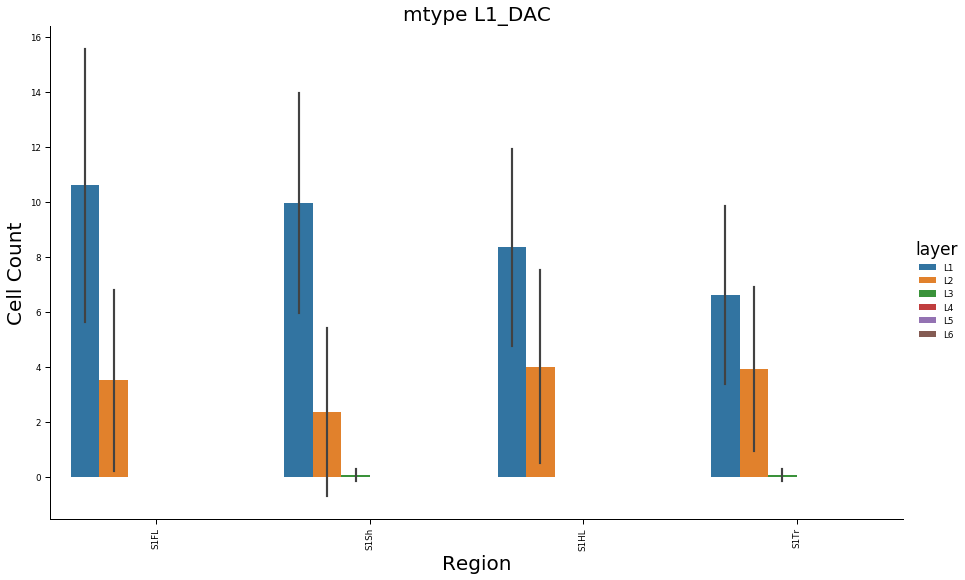

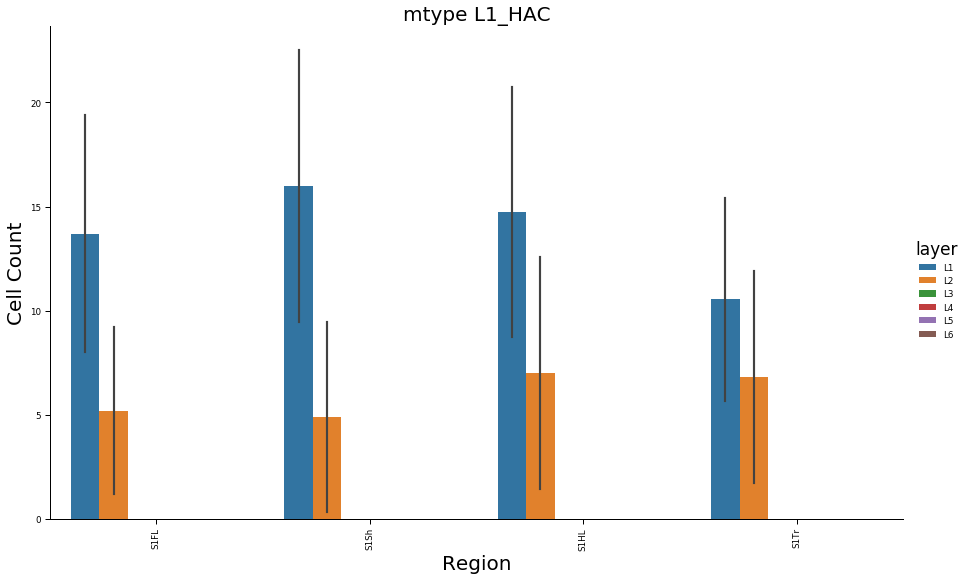

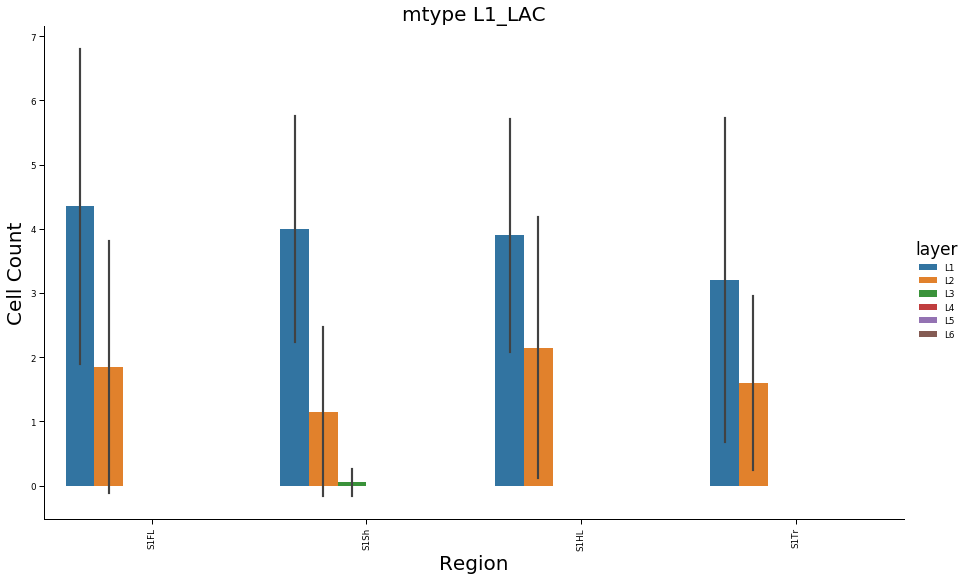

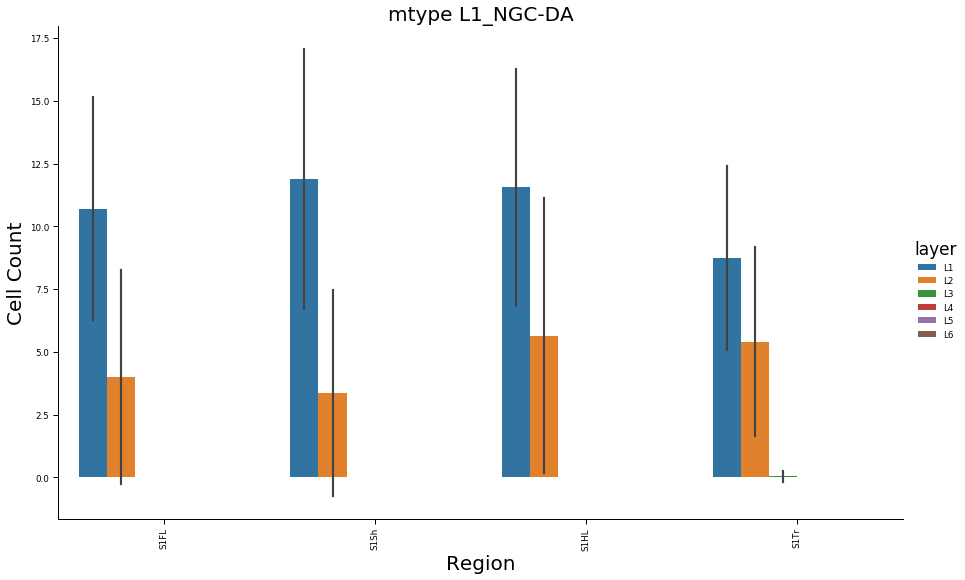

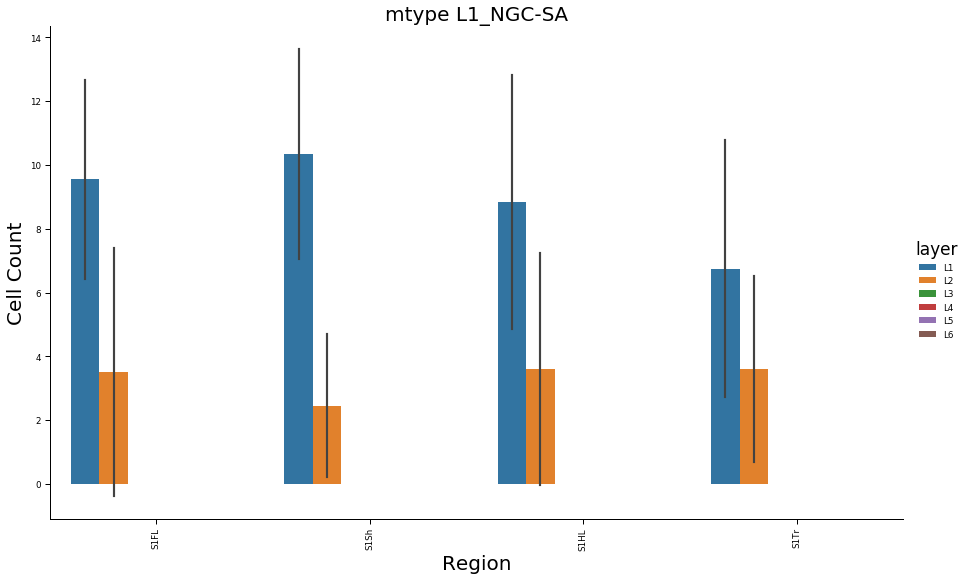

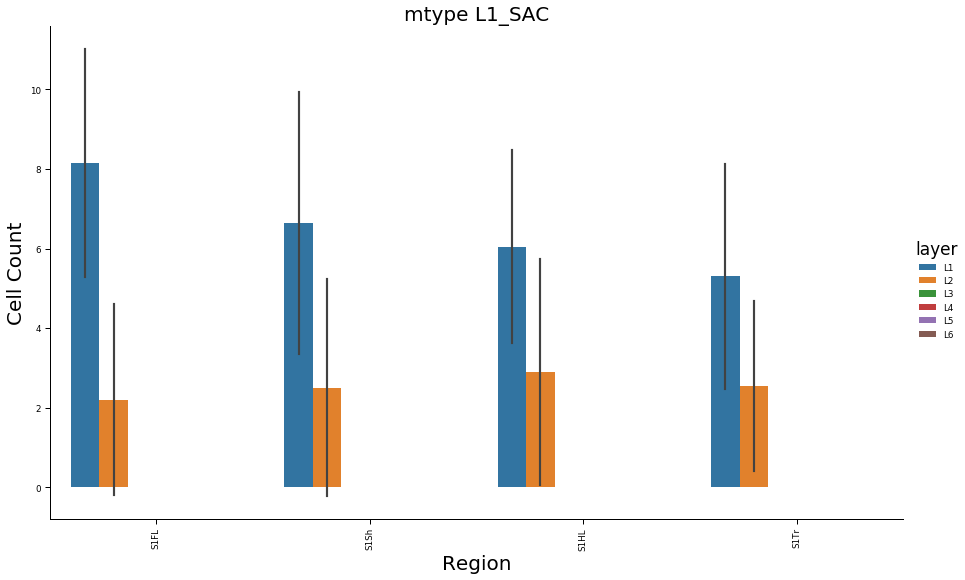

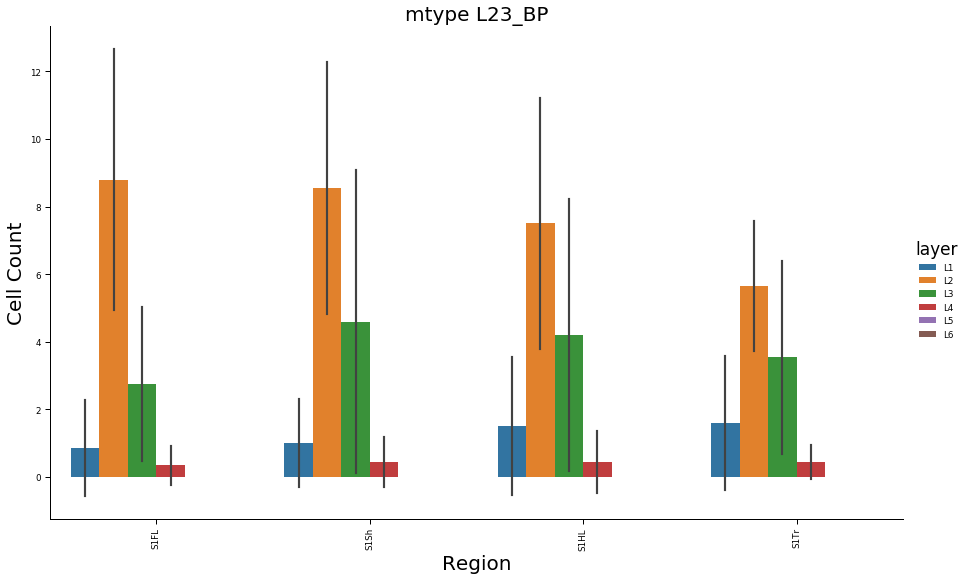

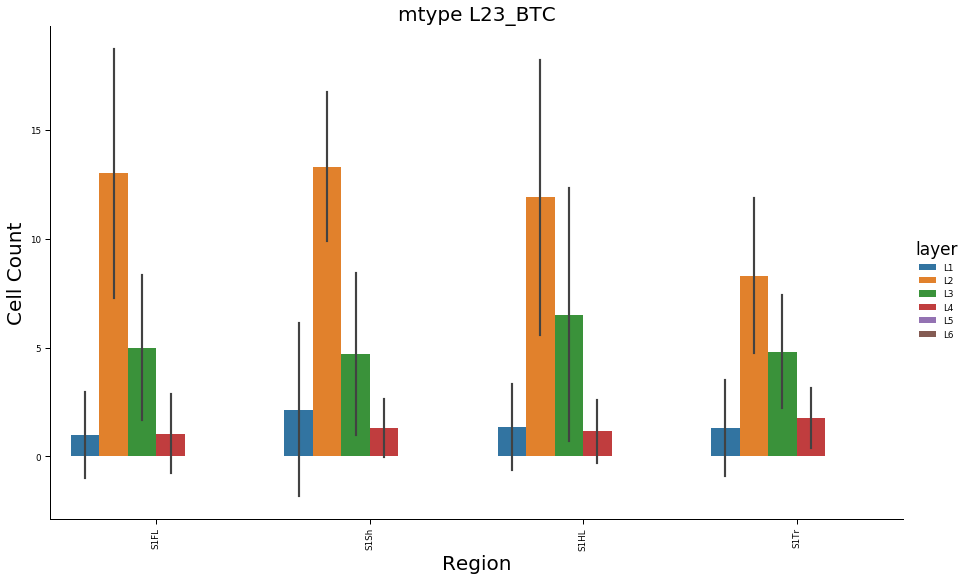

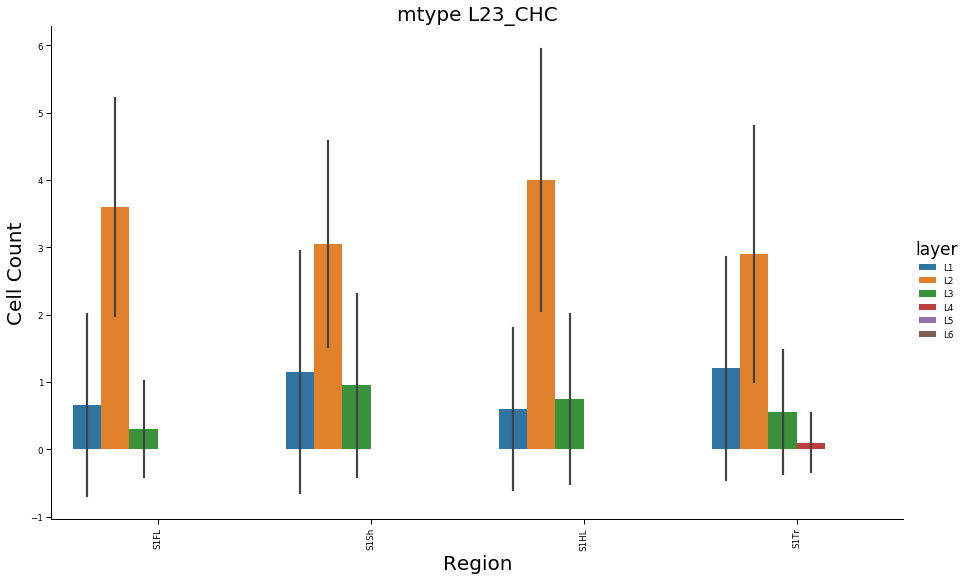

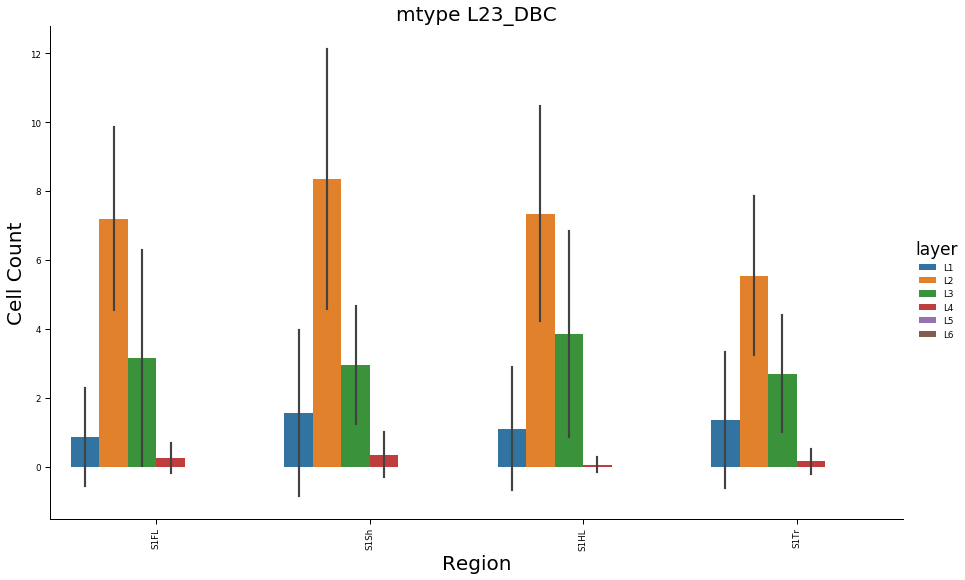

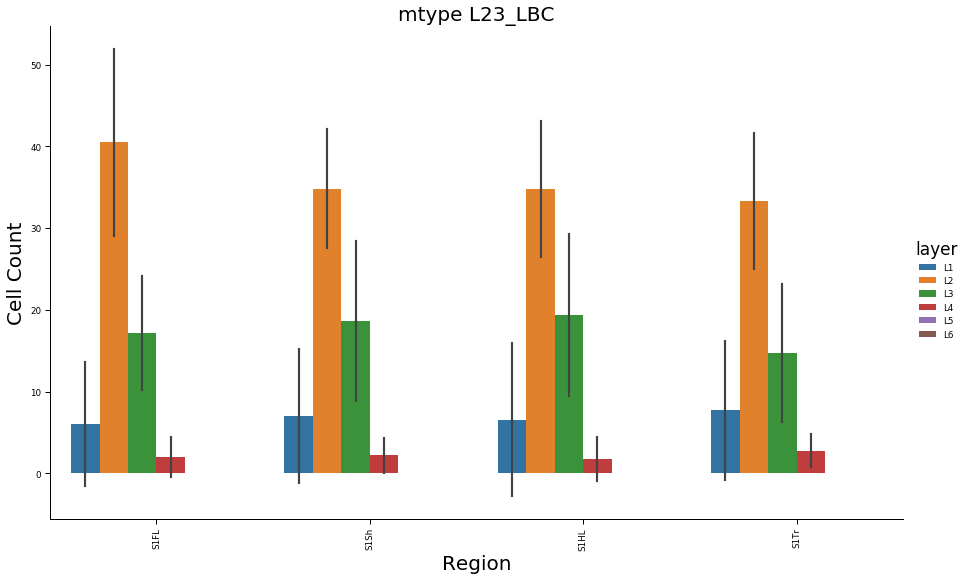

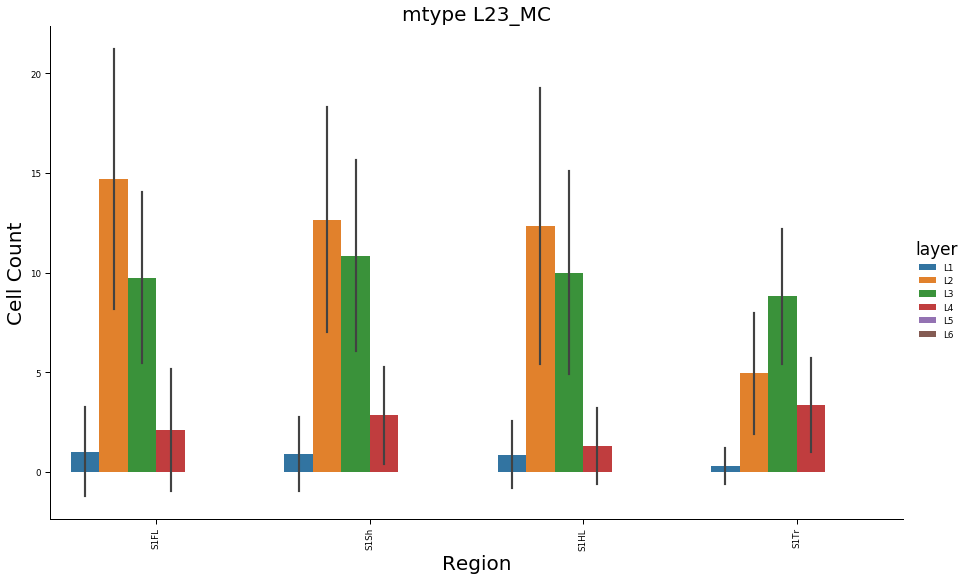

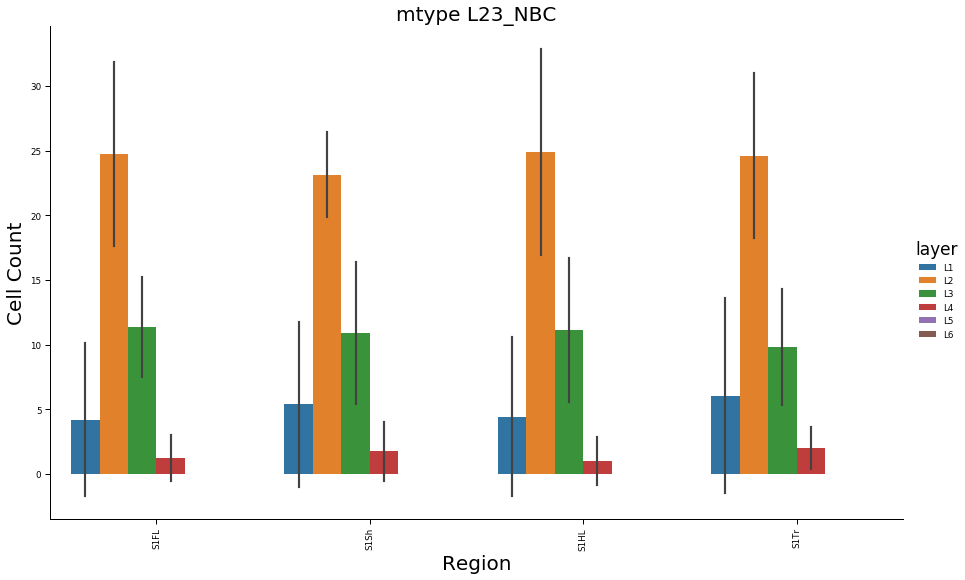

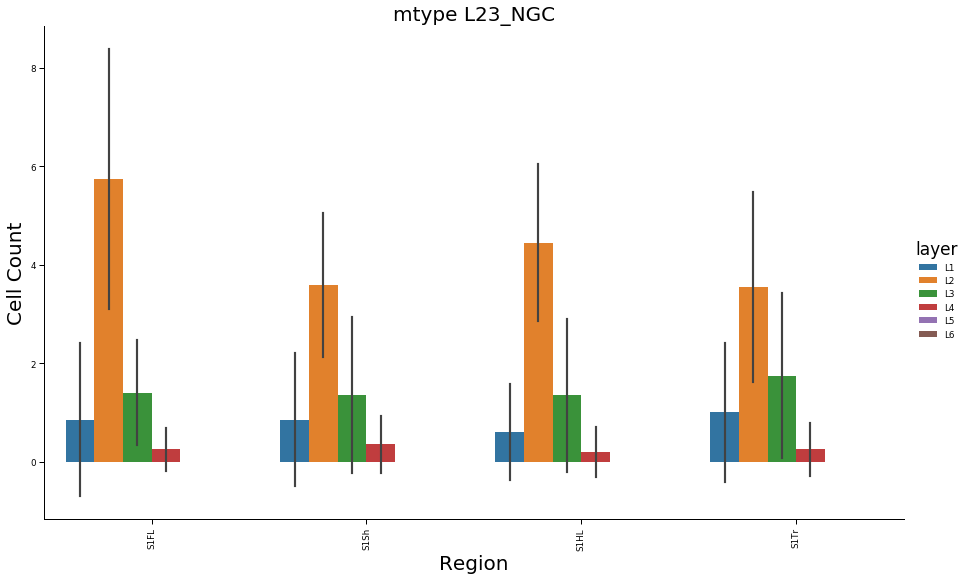

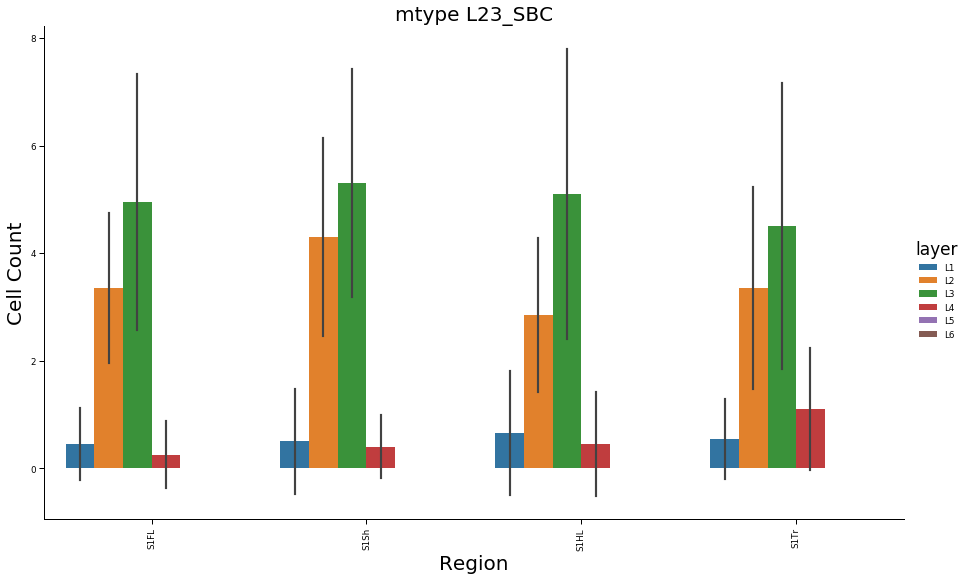

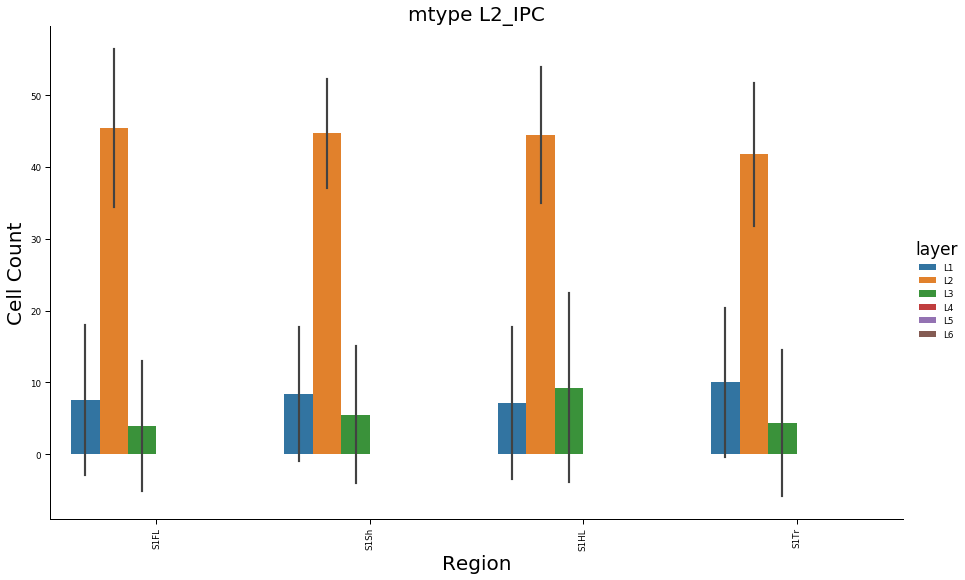

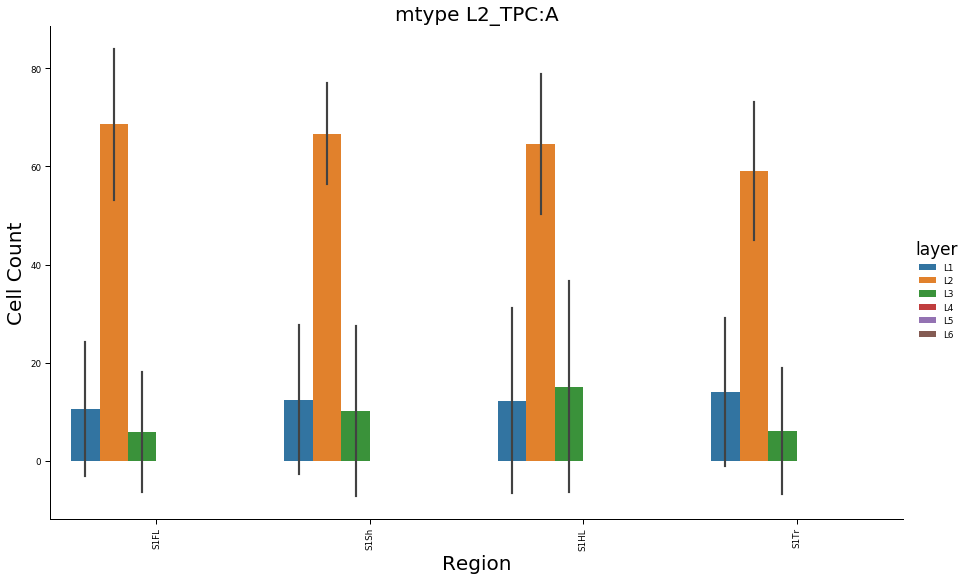

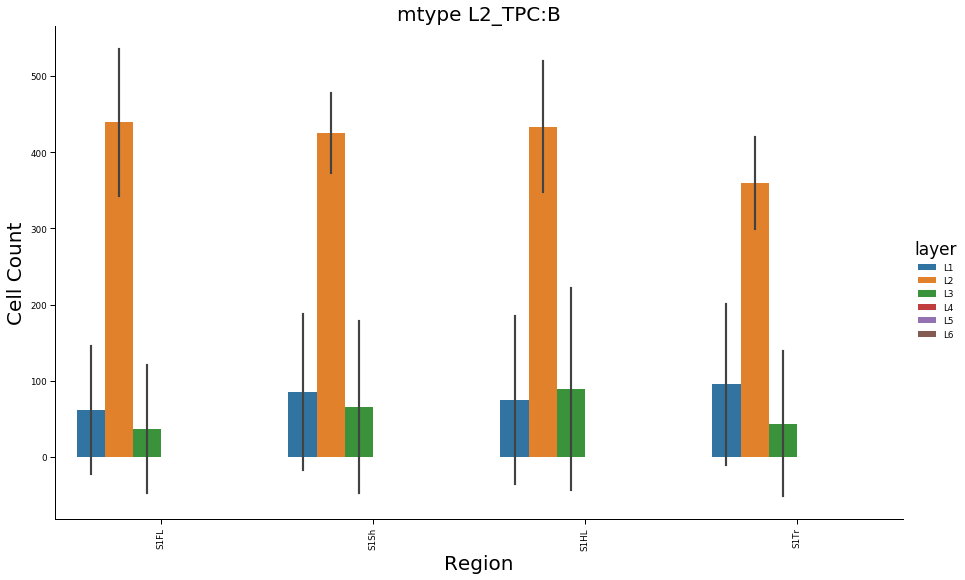

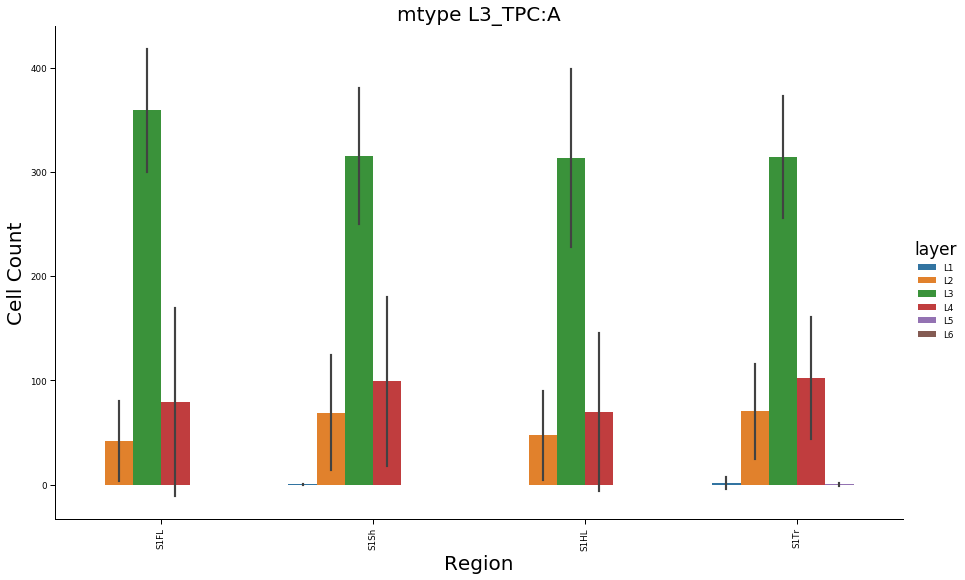

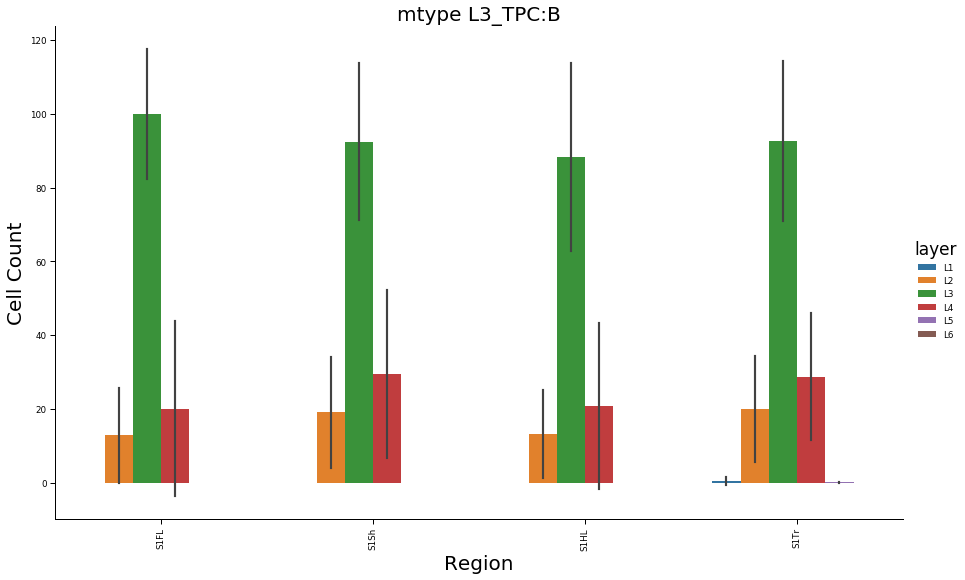

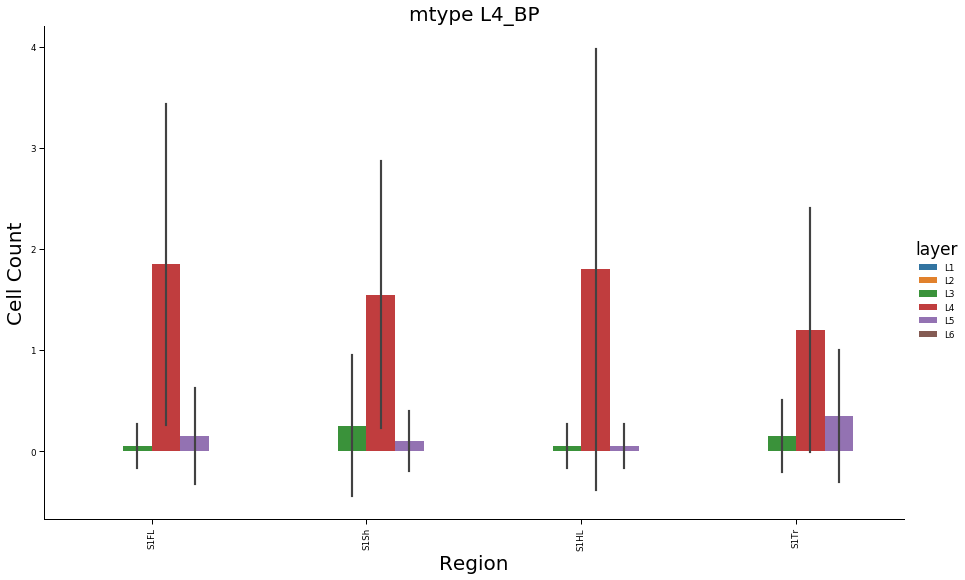

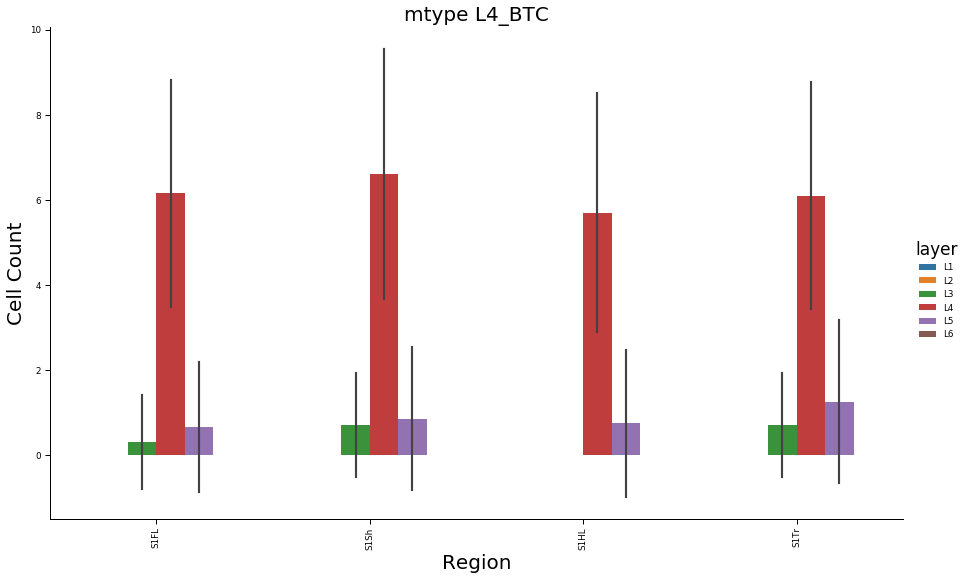

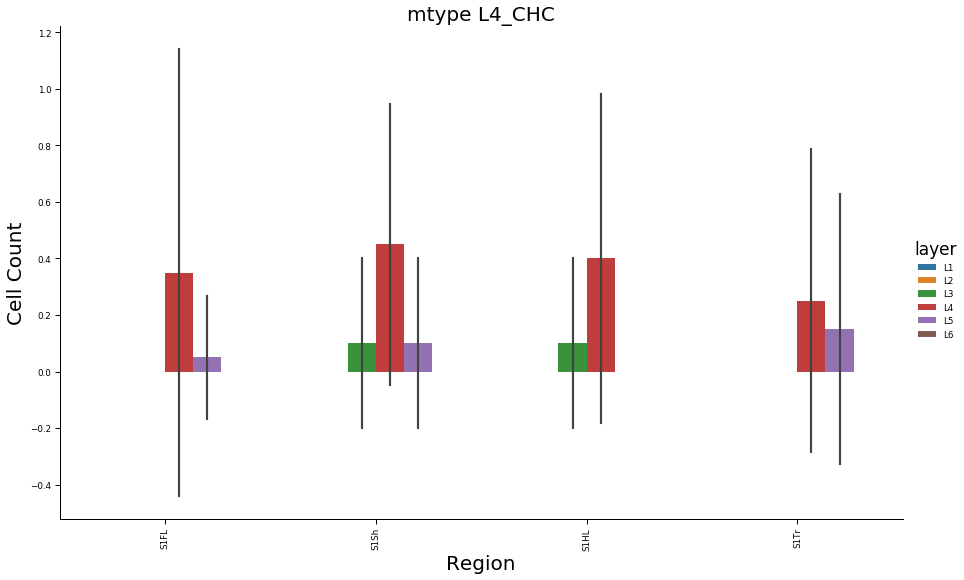

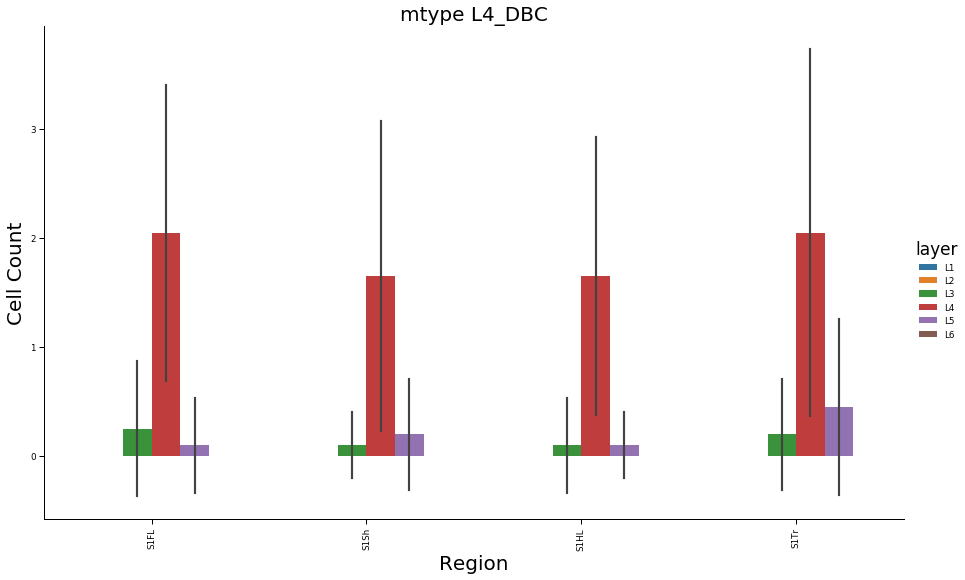

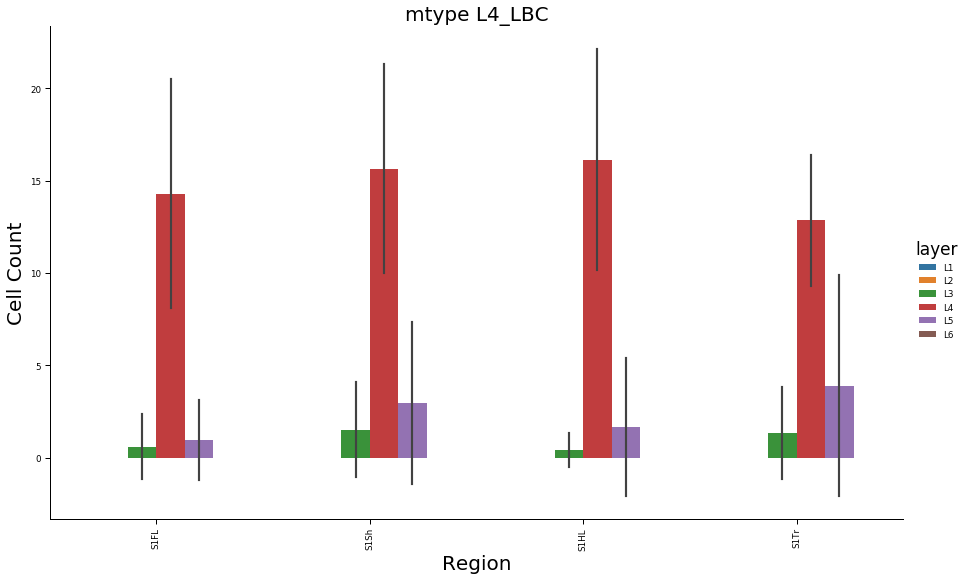

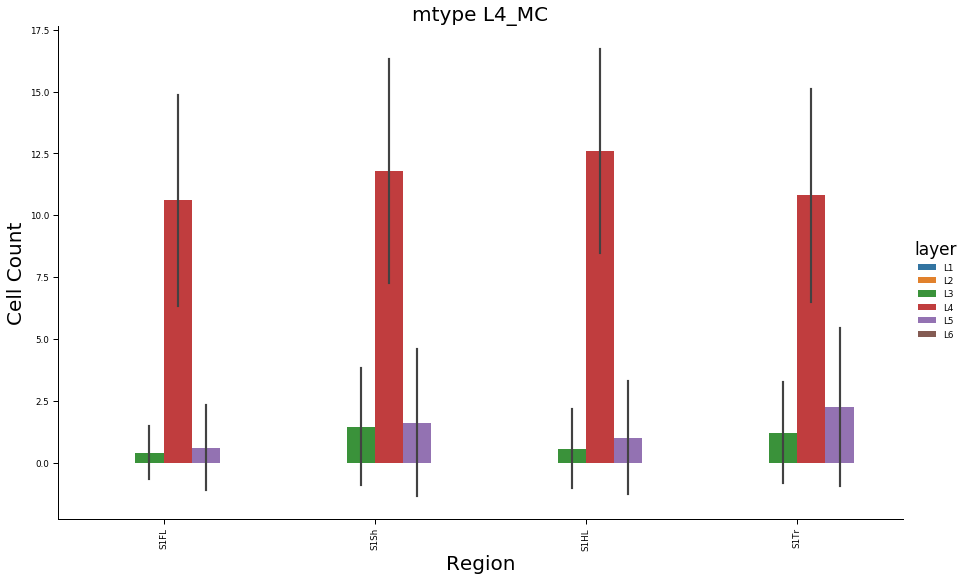

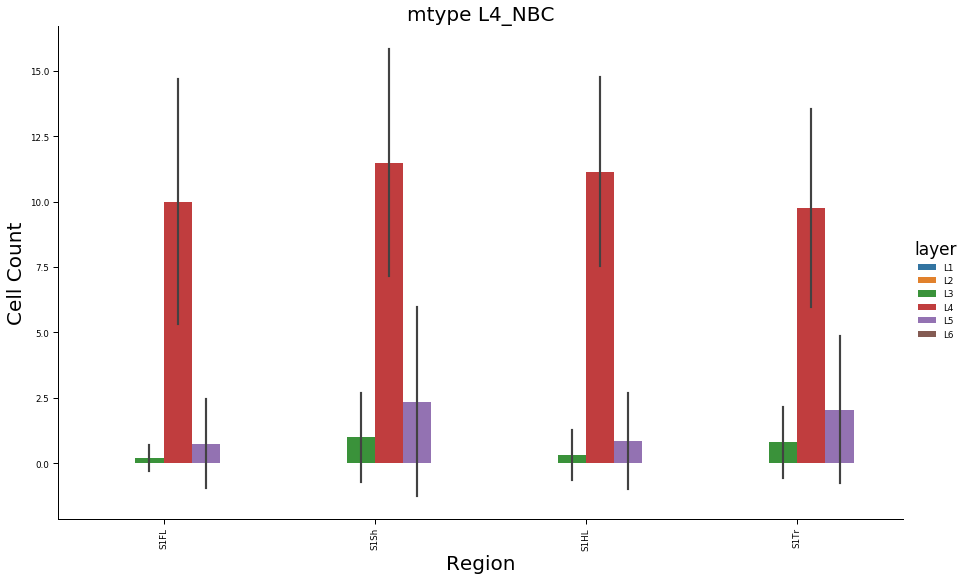

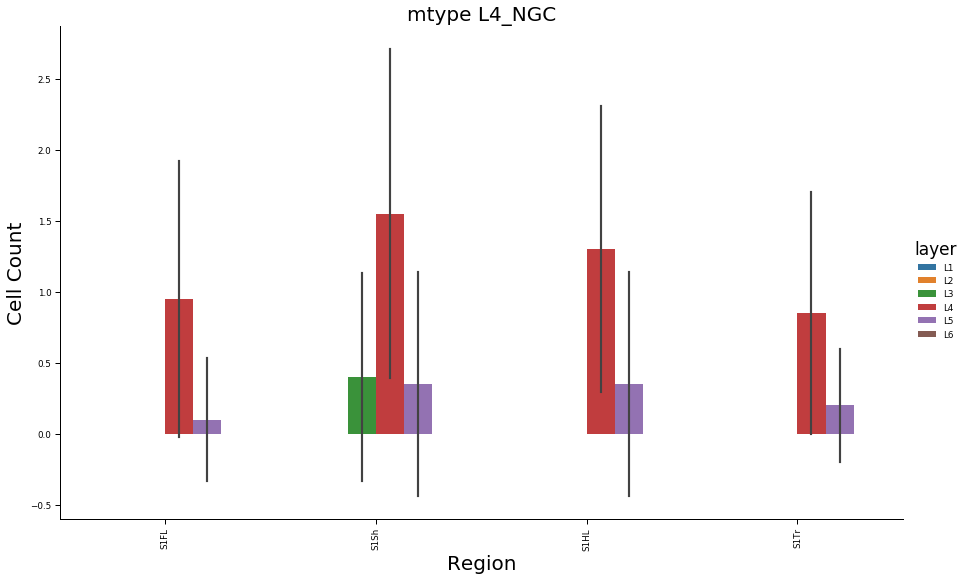

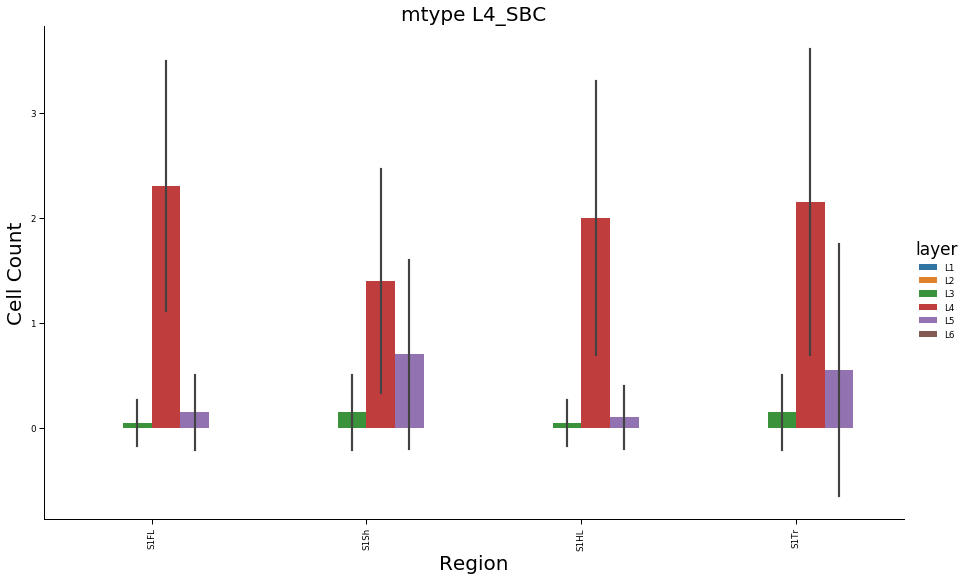

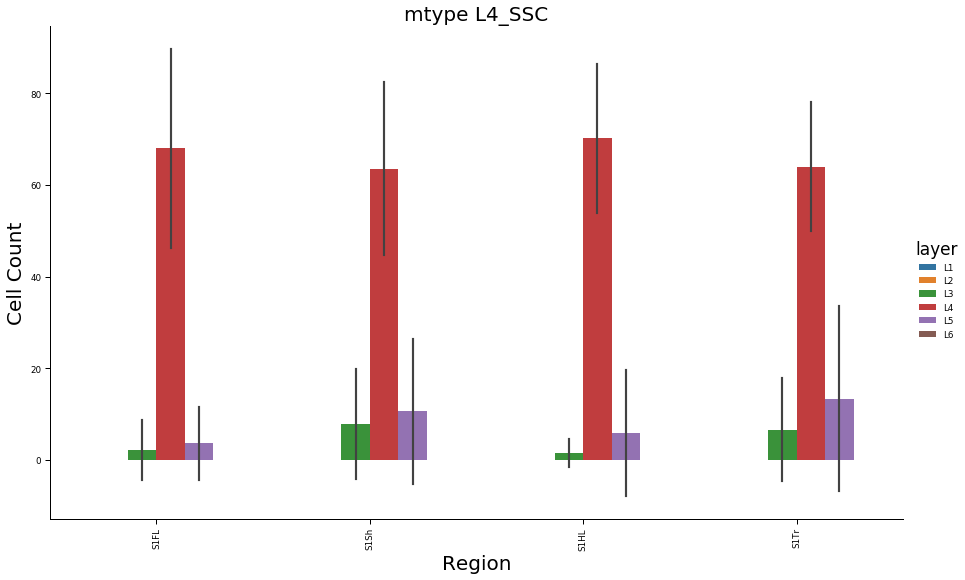

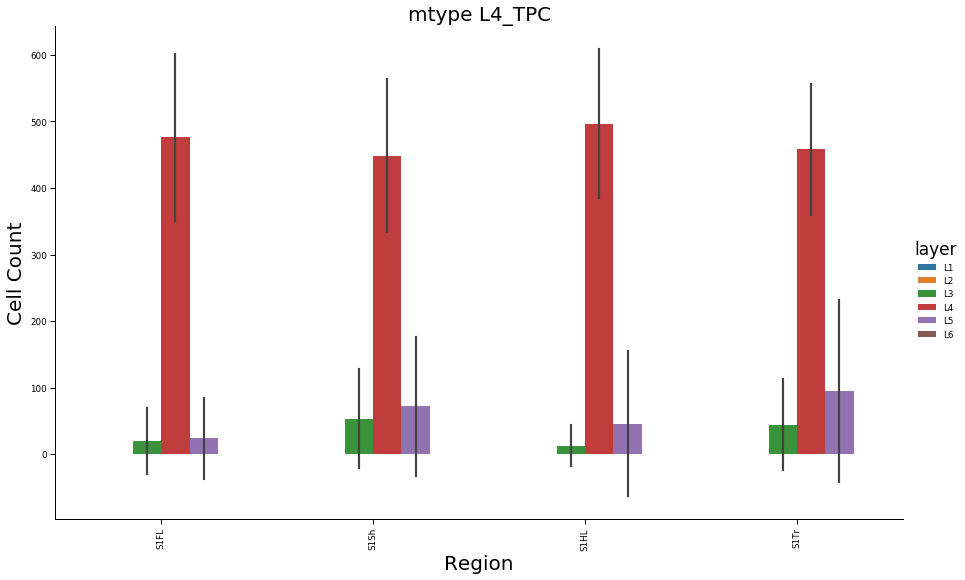

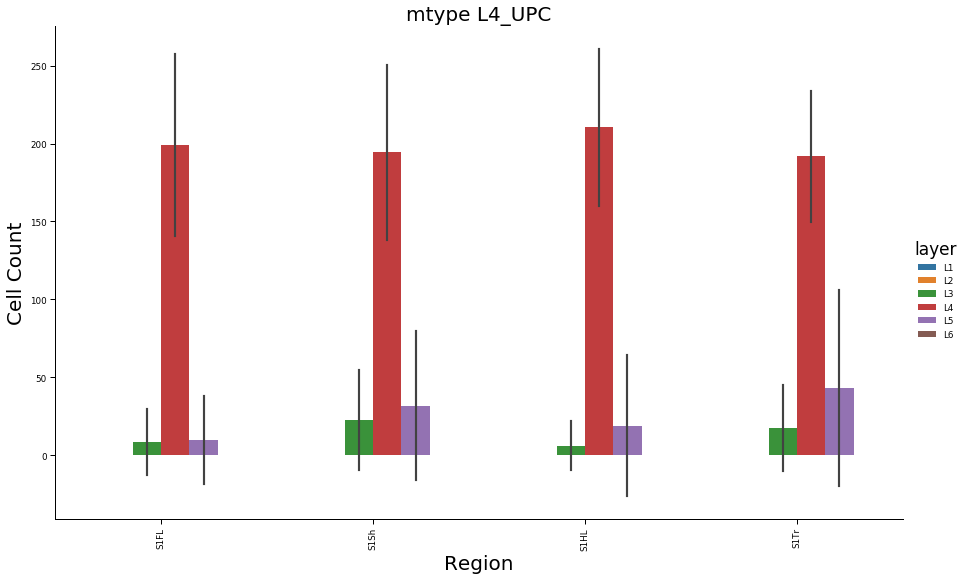

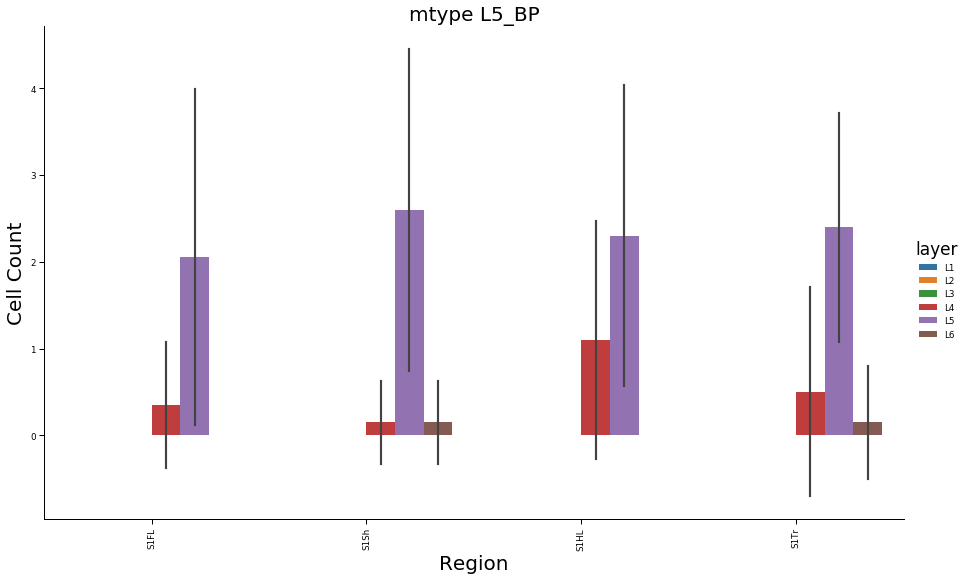

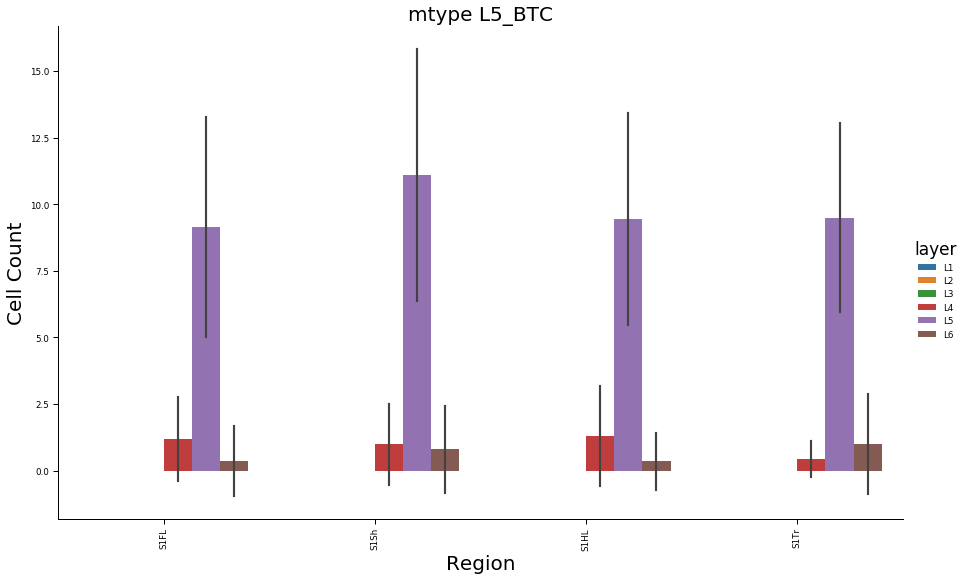

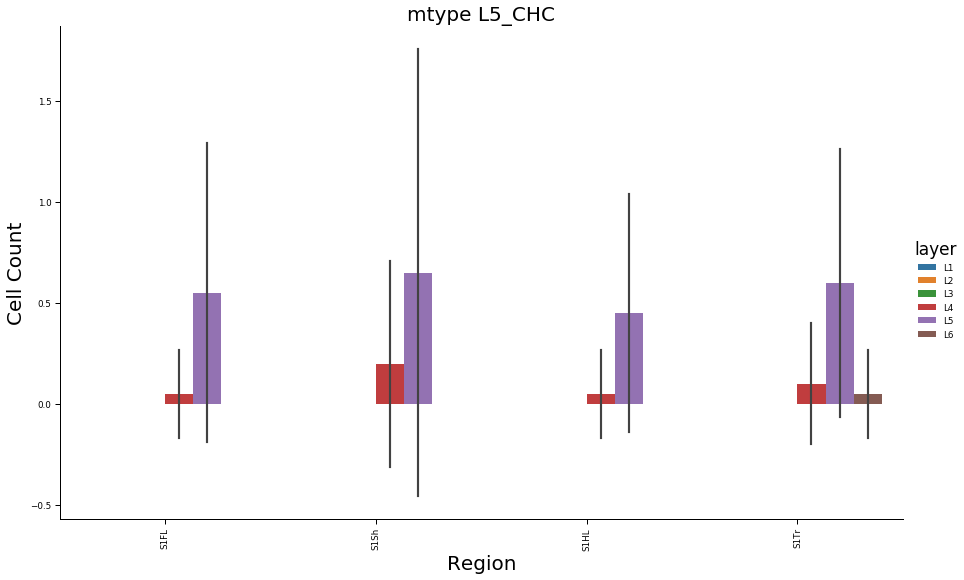

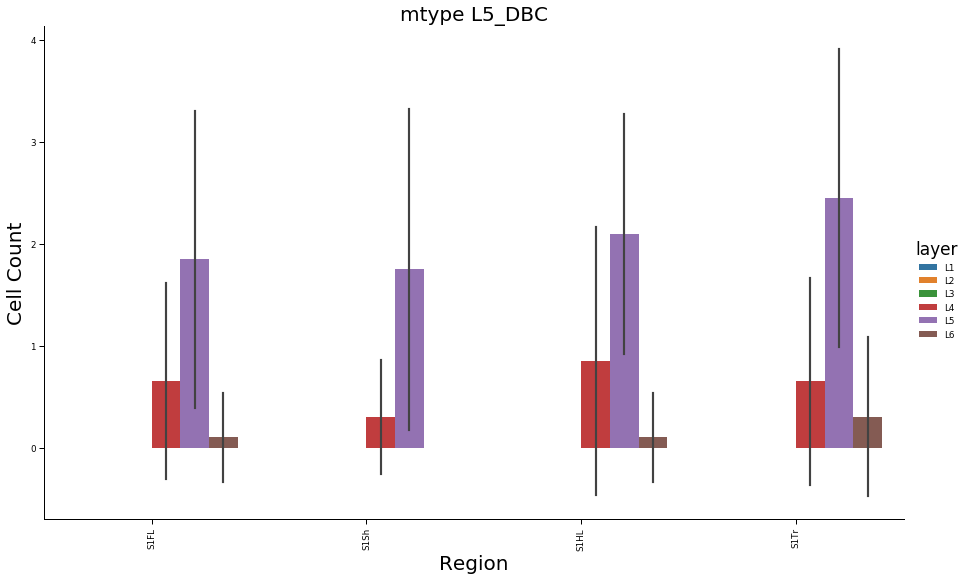

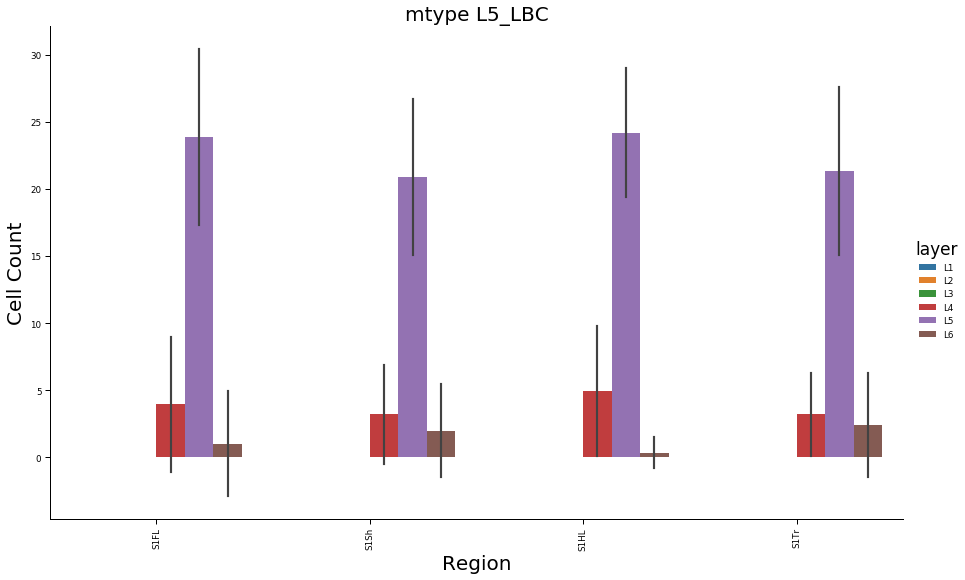

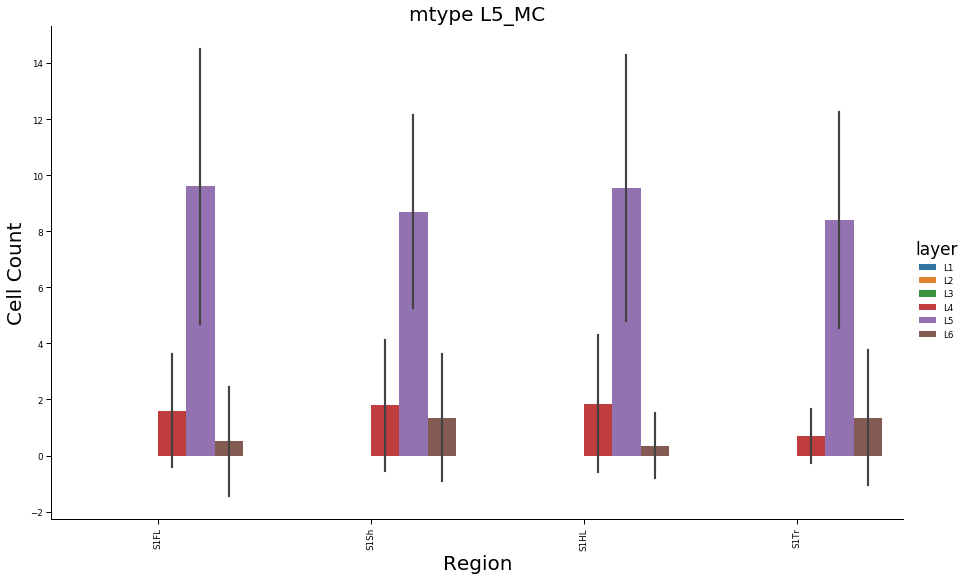

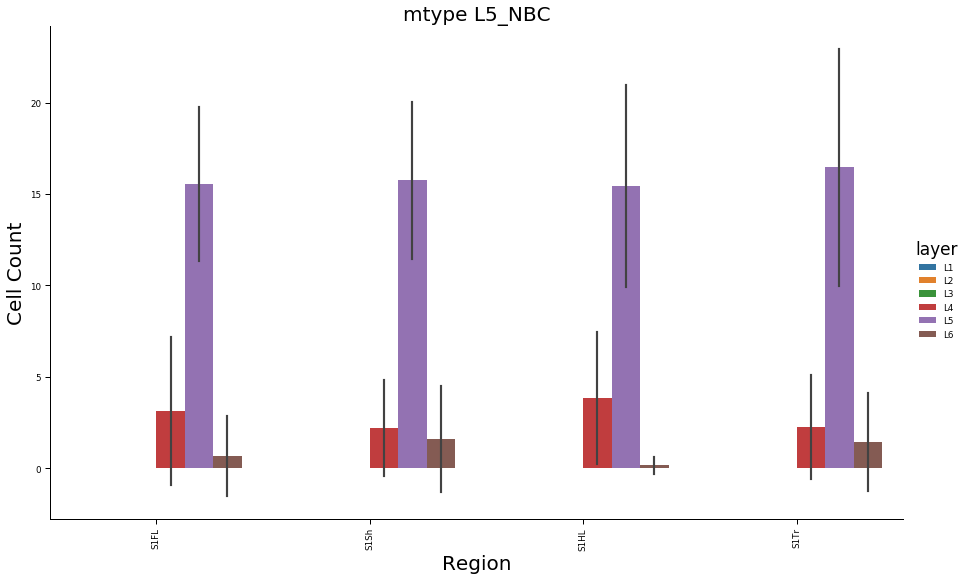

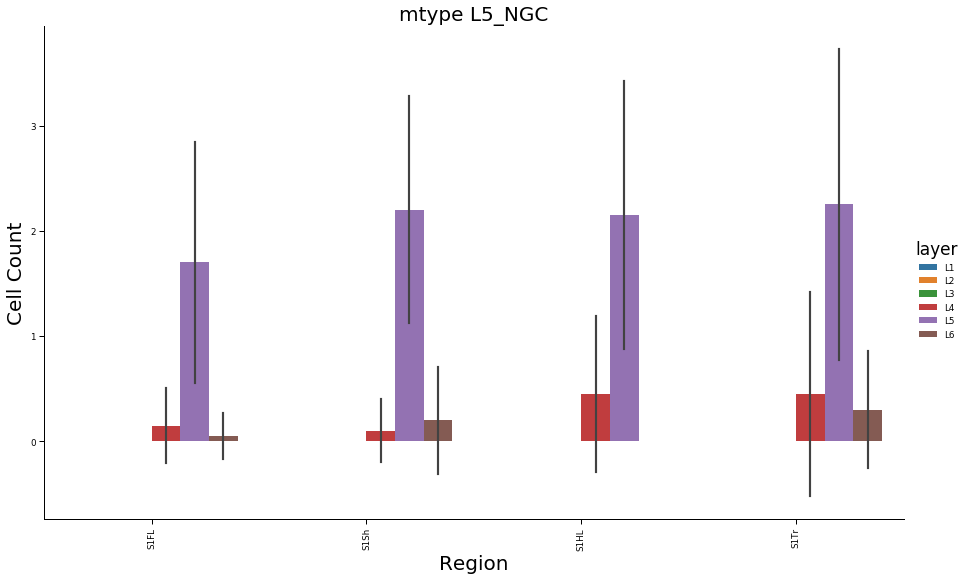

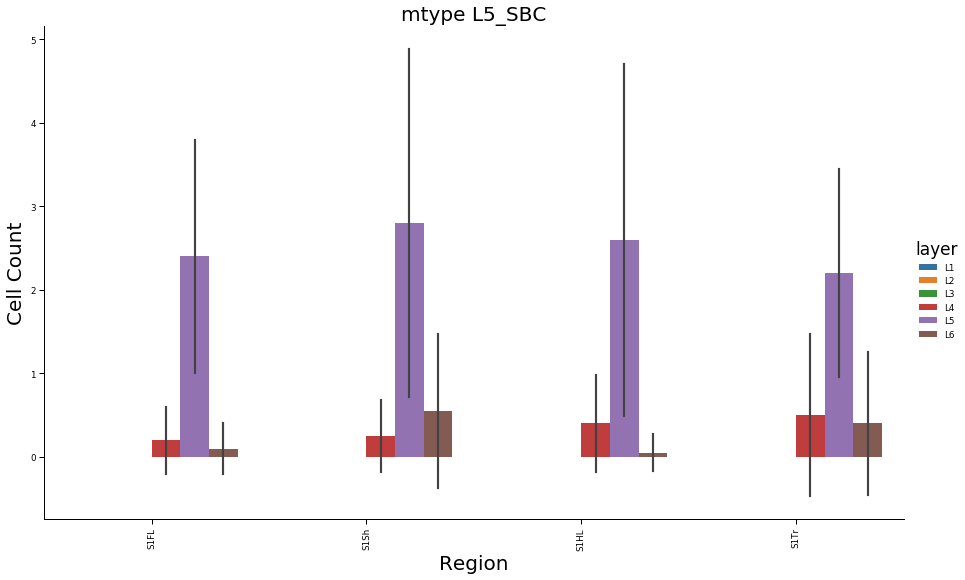

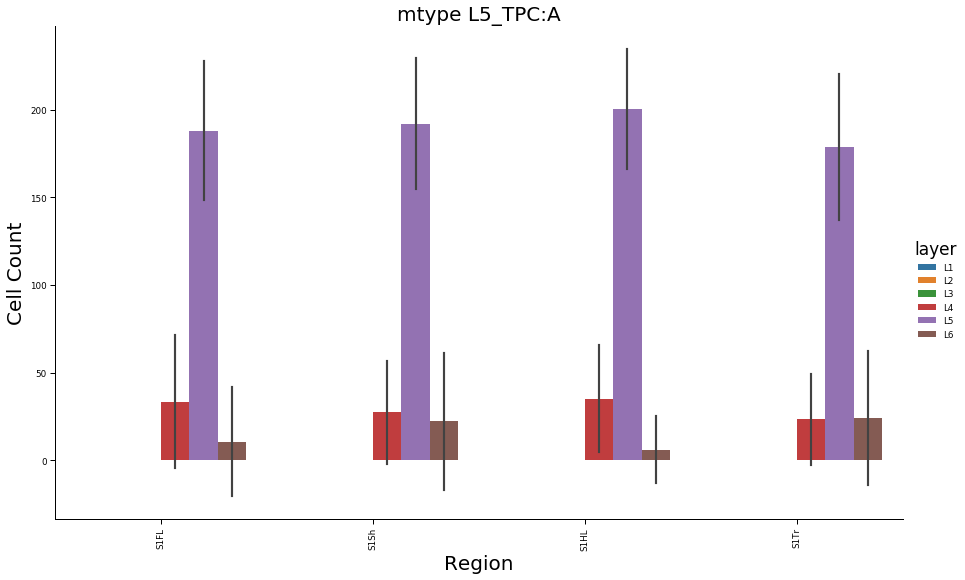

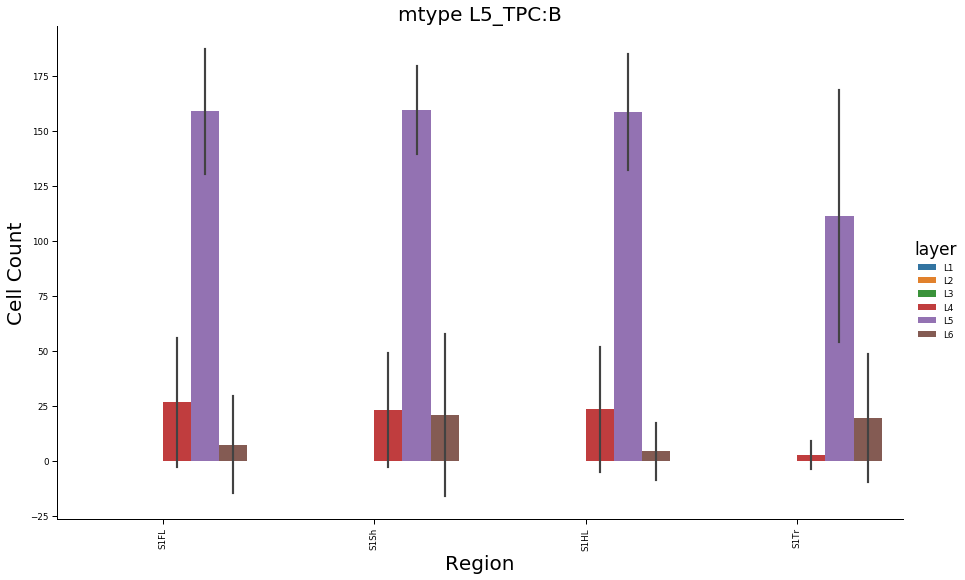

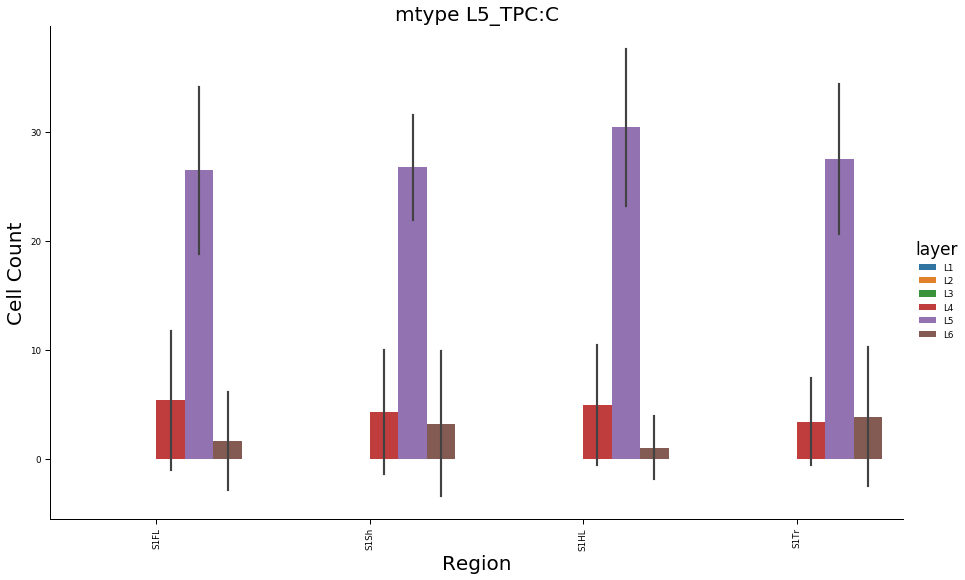

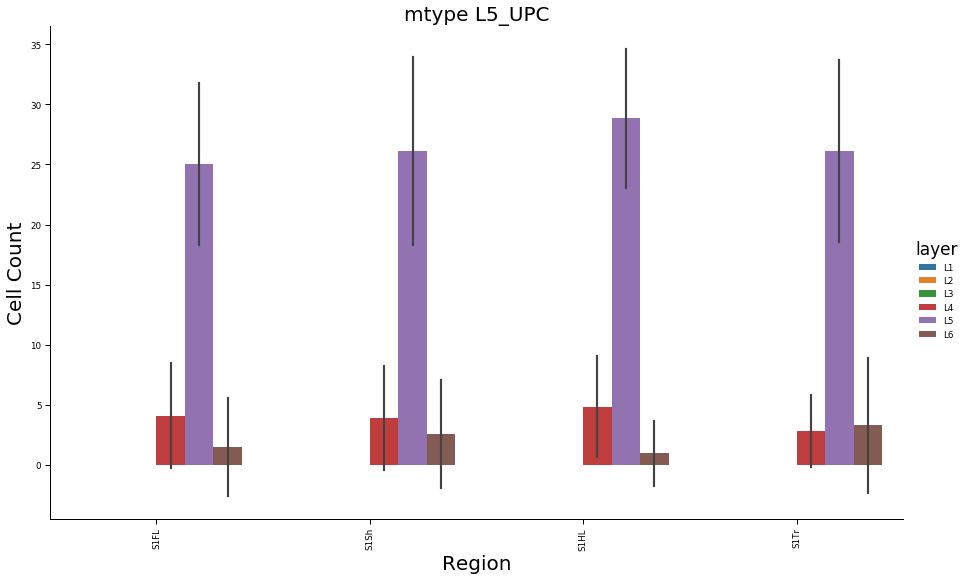

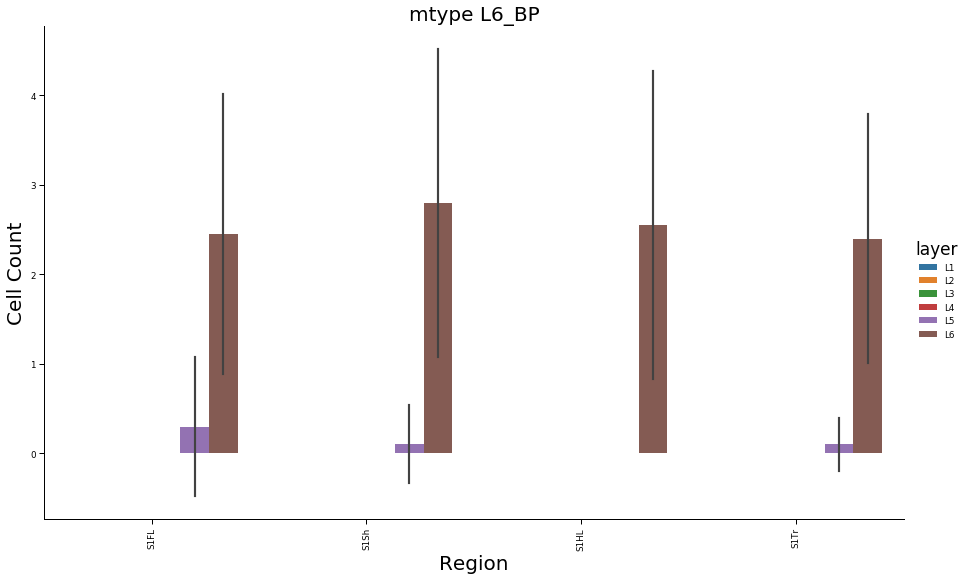

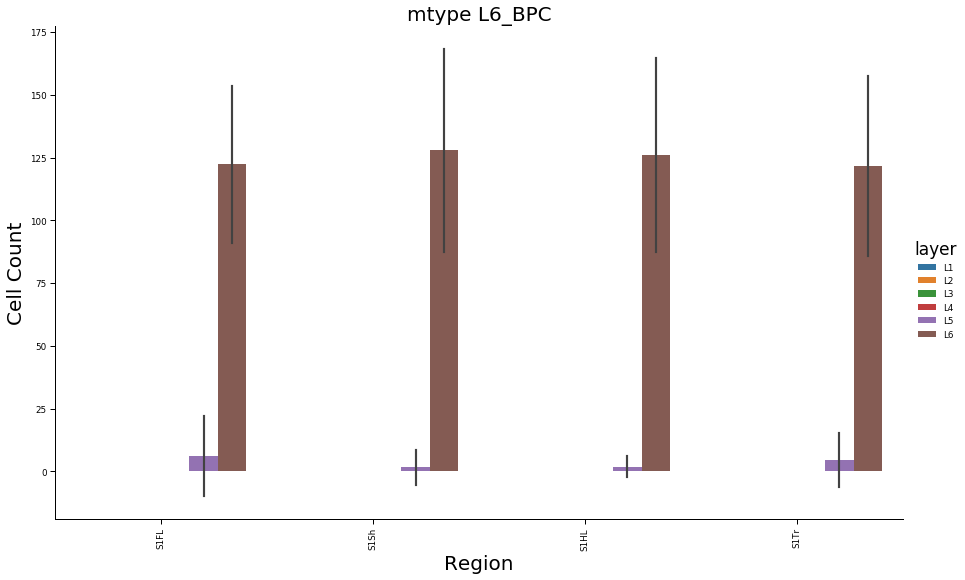

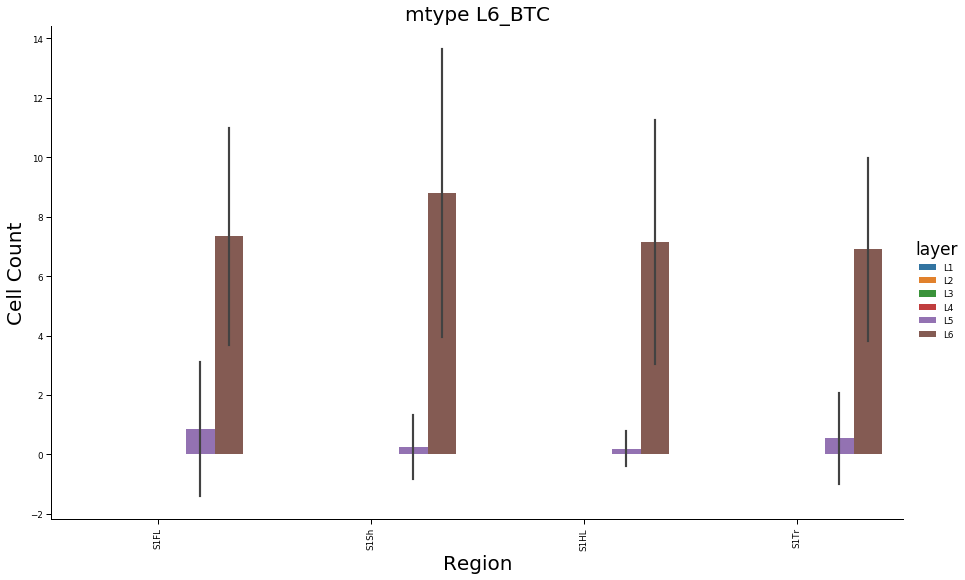

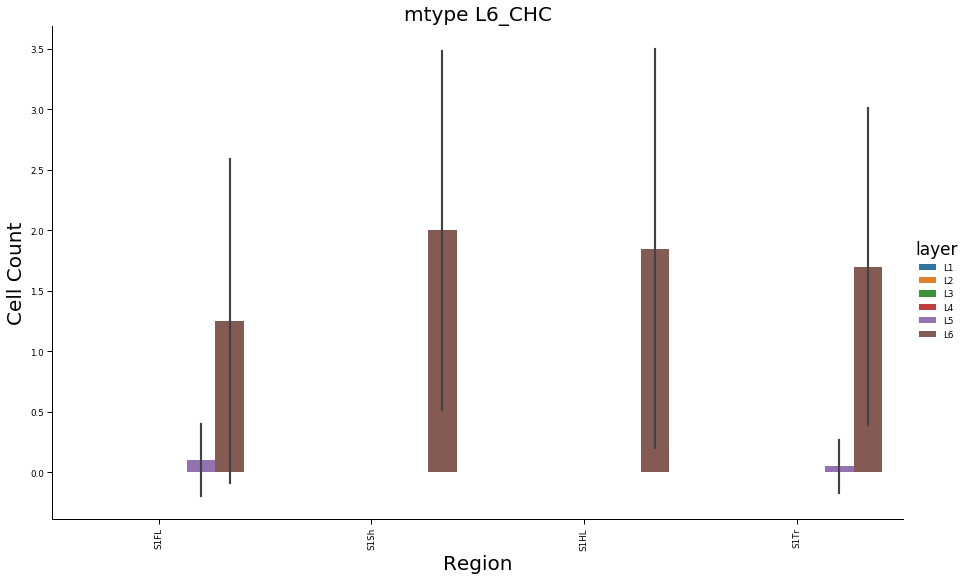

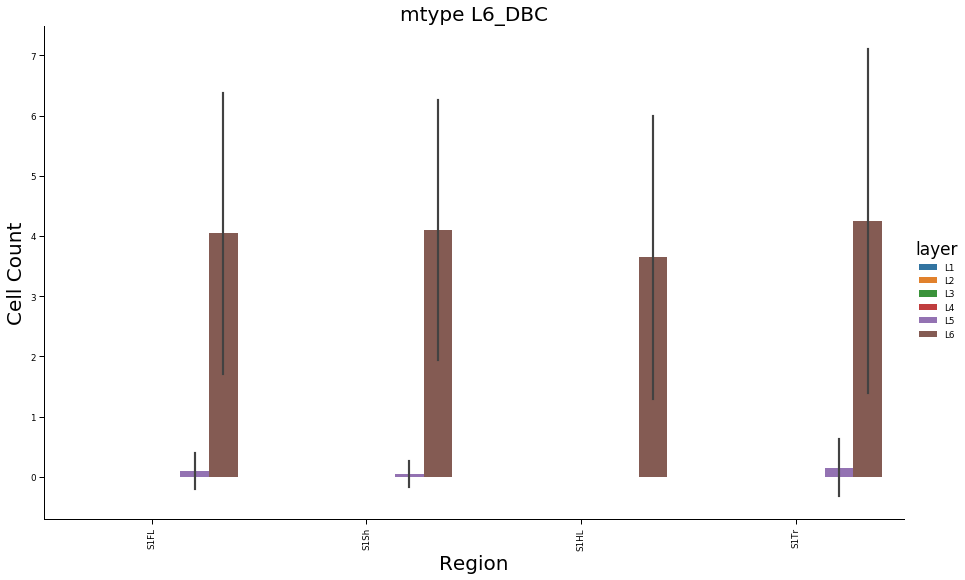

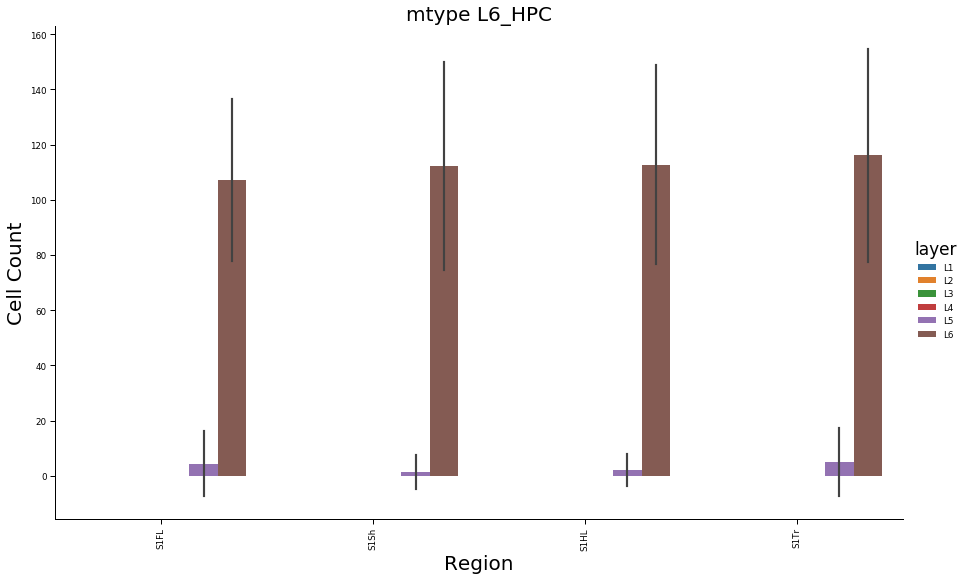

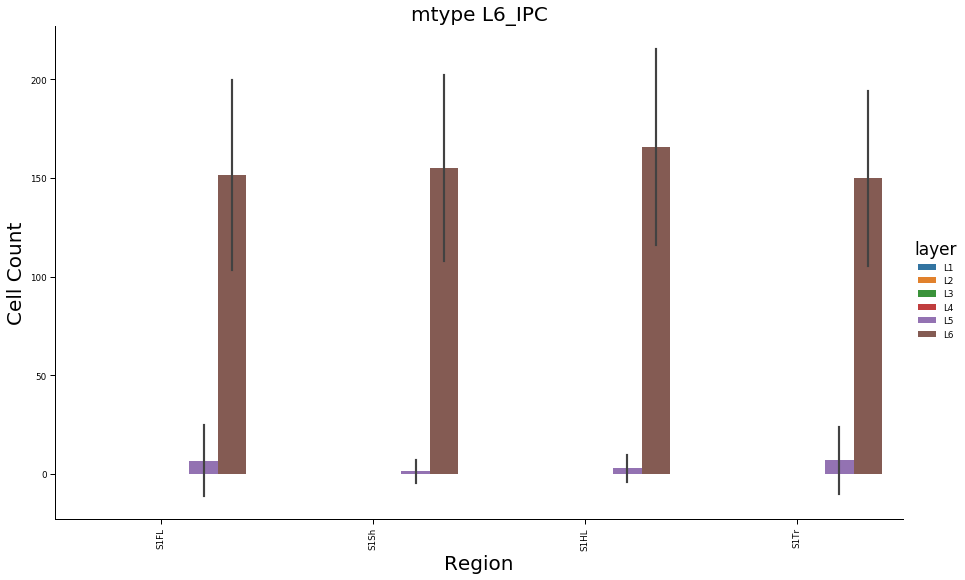

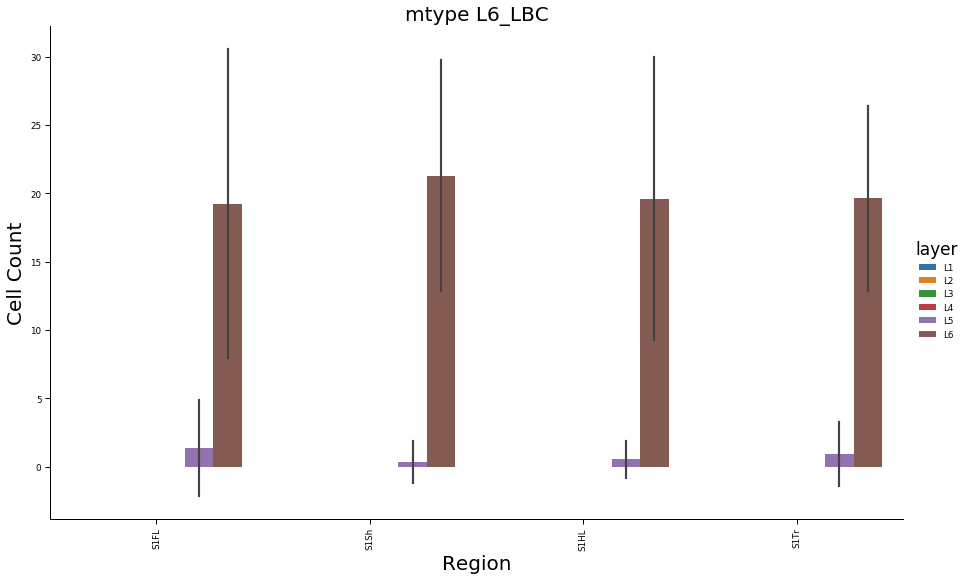

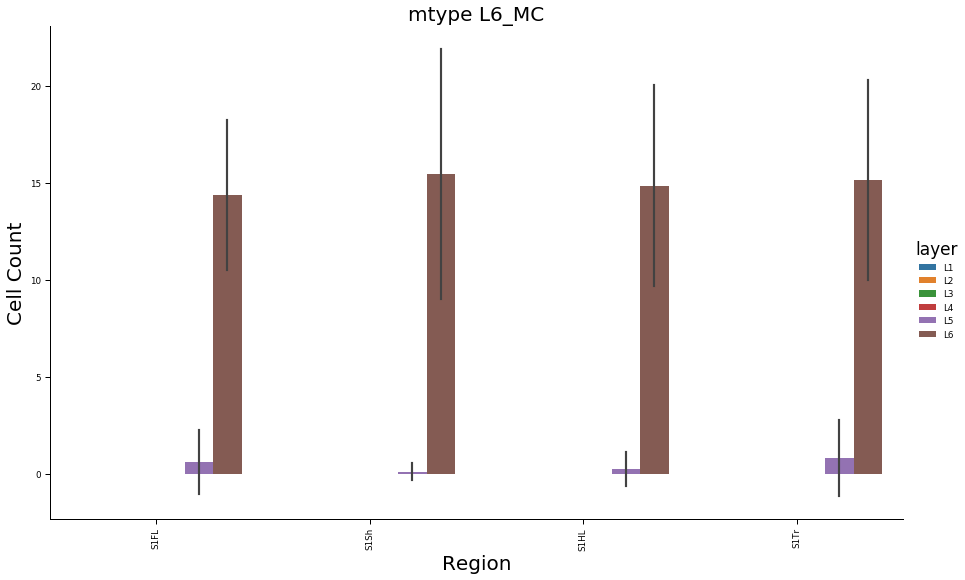

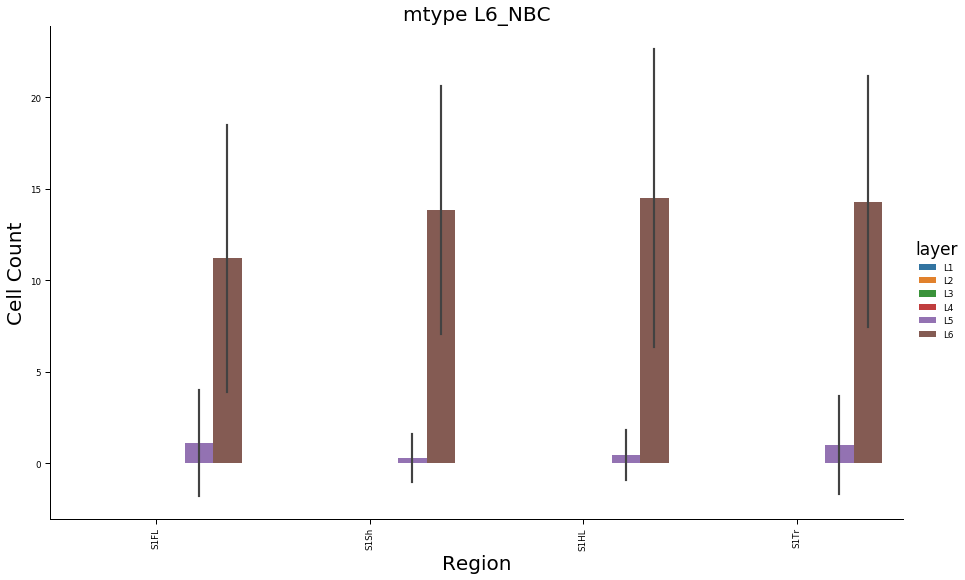

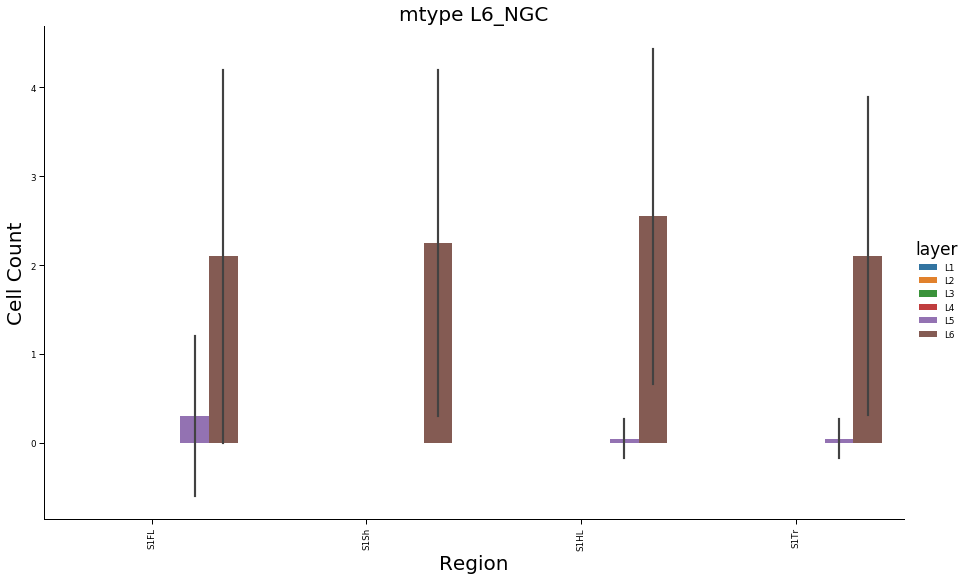

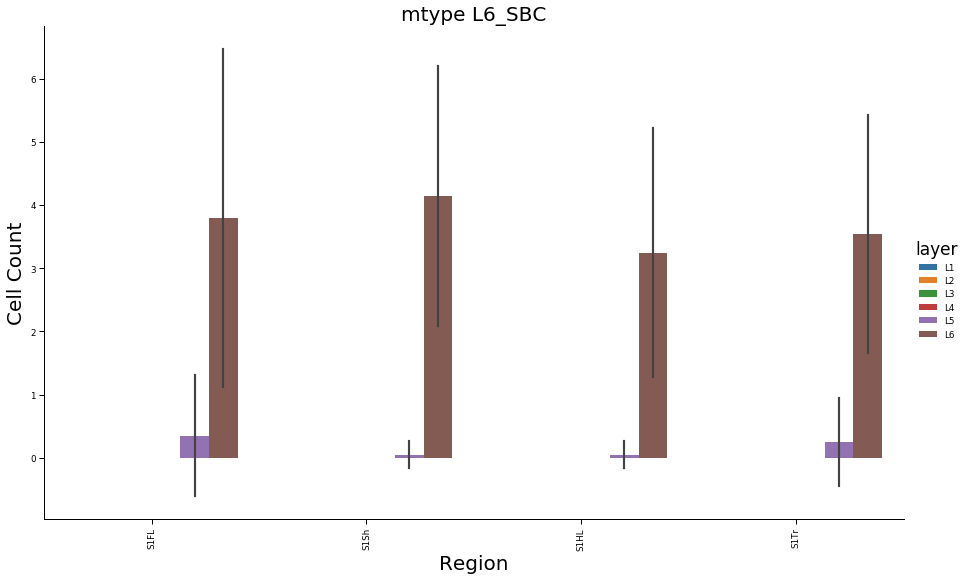

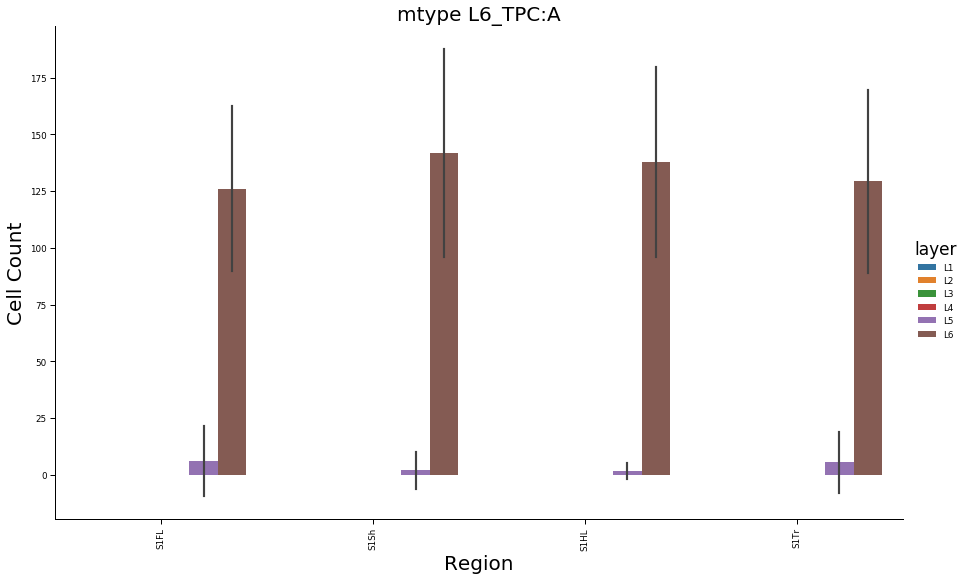

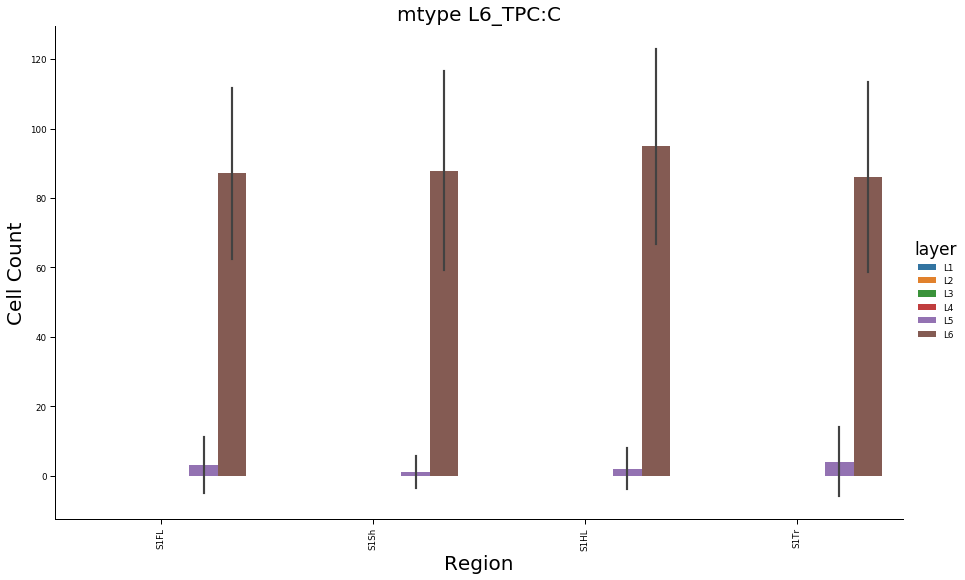

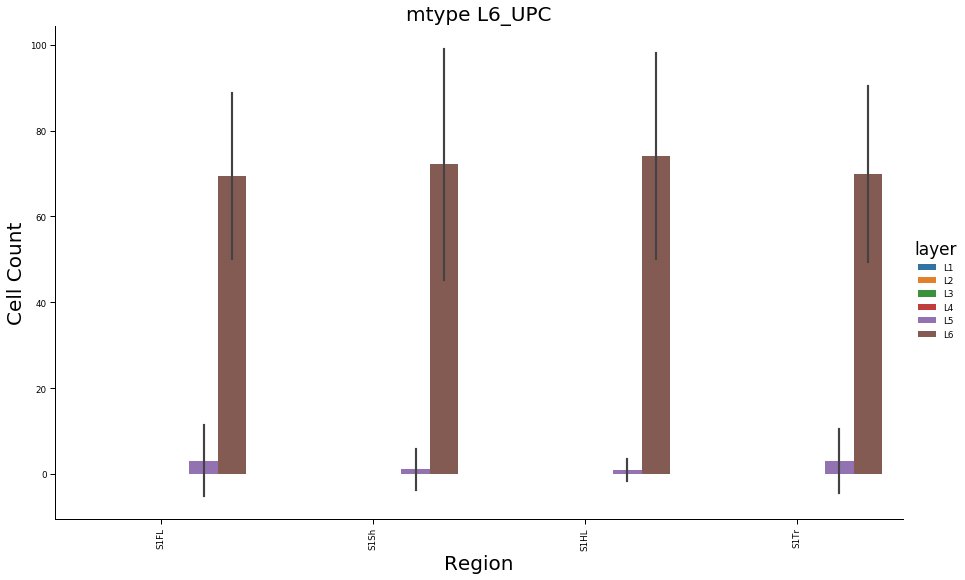

In [133]:
report_mtype_cell_counts =\
    analysis_mtype_cell_count(circuit_model, adapter)

### Cell Density

The number of cells in an volume specified by a region and layer is determined 
by the size of volume.
We can take out the volume by analyzing cell densities.

In [102]:
def measurement_cell_density_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the density of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    
    if box is None:
        return 0.
    count_cells = adapter.get_cells(circuit_model, roi=box).shape[0]
    volume_spatial = box.volume
    return count_cells / volume_spatial

In [103]:
phenomenon["cell_density"] =\
    Phenomenon("Cell Density", 
               description="Number of cells in a unit volume.",
               group="Composition")
    
analysis_cell_density =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_density"],
        introduction="""
        Density of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_density_using_sampling,
        sample_size=20,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="cell_density",
                     ylabel="Cell Density",
                     gvar="region"),
        report=CircuitAnalysisReport)

In [104]:
report_cell_density = analysis_cell_density(circuit_model, adapter)





  0%|          | 0/480 [00:00<?, ?it/s]

NameError: name 'random_box' is not defined

In [59]:
reporter.post(report_cell_density)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 12:29:15>                                                      
Post report cell_density at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025



'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025'

# Connectome

The connectome of a circuit consists of synapses between the cells.

## Efferent connections of cells 

An efferent connection is an outgoing connection,
and the cell in question the pre-synaptic cell.
We have developed to make connectome measurements on the circuit.
We use this tool to define a measurement of efferent degree.

In [99]:
reload(pm)
efferent_degree =\
    pm.PathwayMeasurement(
        direction="EFF",
        value=lambda connections: 1.,
        variable="number_connections_efferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_size=100,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=1000)

In [100]:
efferent_degree.collect(
    circuit_model, adapter,
    pre_synaptic_cell_group={"mtype": "L23_MC"})

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
PathwayMeasurement.sample(...)
with sampling methodology exhaustive

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'EFF', 'post_synaptic_cell_group': {}, 'pre_synaptic_cell_group': {'mtype': 'L23_MC'}}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python

ImportError: dlopen(/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/libsonata.cpython-37m-darwin.so, 2): Library not loaded: /usr/local/lib/libhdf5.101.dylib
  Referenced from: /Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/libsonata.cpython-37m-darwin.so
  Reason: image not found